# The Impact of Reddit Users on Financial Market Dynamics  (BBBY Shares Case Study)

**Links to the datasets used in the project**: 
- Academic Torrents with full Reddit dataset: https://academictorrents.com/details/c398a571976c78d346c325bd75c47b82edf6124e 
- JSON with filtered posts https://drive.google.com/file/d/1-Jz3VBoD209_MvcMbfFCd_pD0YE4dXyJ/view?usp=share_link
- JSON with filtered comments https://drive.google.com/file/d/1rXuwMwDiVPR9Hh2fWgj_nzqvmvgTQnl-/view?usp=share_link
- CSV with BBBY shares prices parced from Yahoo finances https://drive.google.com/file/d/15Oq7pPsquZ-R2uQG-IXPlzieE28gFQIq/view?usp=share_link 
- CSV with 'BBBY' search from Google Trends data https://drive.google.com/file/d/1YPJ2jom3aBnL-vECG1QlSmFkm6Dq531t/view?usp=share_link 
- CSV with 'Bed Bath and Beyond' search from Google Trends data  https://drive.google.com/file/d/13WDpGVLWct8kSTHKYlMYIb1k8wYkVsLm/view?usp=share_link
- CSV with news search data https://drive.google.com/file/d/1KZL3_zcpSzwvtPB1lIQnStcnqOr99vZp/view?usp=share_link 

In [1]:
# data retrieving 
import zstandard
import os
import logging.handlers
import yfinance as yf

# data analysis
import json
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta

# sentiment analysis 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# network analysis 
import networkx as nx

# visualisation
import matplotlib.pyplot as plt

## 1. Data decompression and filtering

### 1.1 Posts decompression

In [8]:
log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = reader.read(2**27).decode()
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line, file_handle.tell()

            buffer = lines[-1]
        reader.close()

In [3]:
# Getting posts
if __name__ == "__main__":
    file_path = 'wallstreetbets_submissions.zst'
    output_file_path = 'output.json'
    file_size = os.stat(file_path).st_size
    file_lines = 0
    file_bytes_processed = 0
    created = None
    field = "subreddit"
    value = "wallstreetbets"
    bad_lines = 0
    output_data = []

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)
            created = datetime.utcfromtimestamp(int(obj['created_utc']))
            temp = obj[field] == value
            output_data.append(obj)
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

    # Save the JSON data to the output file
    with open(output_file_path, 'w') as output_file:
        json.dump(output_data, output_file)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")

2017-12-05 19:20:38 : 100,000 : 0 : 31,720,150:9%
2019-02-13 20:20:08 : 200,000 : 0 : 42,861,525:12%
2020-02-28 17:48:51 : 300,000 : 0 : 61,736,325:18%
2020-06-03 03:34:06 : 400,000 : 0 : 81,266,500:23%
2020-10-21 14:13:22 : 500,000 : 0 : 98,175,175:28%
2021-01-21 20:35:44 : 600,000 : 0 : 121,113,300:35%
2021-01-27 19:08:21 : 700,000 : 0 : 133,827,575:38%
2021-01-28 15:44:52 : 800,000 : 0 : 140,381,325:40%
2021-01-29 02:29:30 : 900,000 : 0 : 152,440,225:44%
2021-01-29 23:50:23 : 1,000,000 : 0 : 163,843,750:47%
2021-01-31 22:44:22 : 1,100,000 : 0 : 175,640,500:50%
2021-02-02 12:30:21 : 1,200,000 : 0 : 188,354,775:54%
2021-02-04 14:06:48 : 1,300,000 : 0 : 194,646,375:56%
2021-02-11 12:51:48 : 1,400,000 : 0 : 207,884,950:60%
2021-02-28 17:13:25 : 1,500,000 : 0 : 221,123,525:64%
2021-03-20 23:55:37 : 1,600,000 : 0 : 241,571,225:69%
2021-05-18 02:23:24 : 1,700,000 : 0 : 255,334,100:73%
2021-06-22 17:14:48 : 1,800,000 : 0 : 269,228,050:77%
2021-10-03 07:07:51 : 1,900,000 : 0 : 283,384,150:81

### 1.2 Posts filtering

In [2]:
# Search the posts with BBBY mentions
# Open the Output JSON file with all WSB posts 
with open('output.json', 'r') as f:
    posts = json.load(f)
    
# Key words
keywords = ['BBBYQ', 'BBBY', '$BBBY', 'Bed Bath And Beyond', 'Bed Bath & Beyond']

# Compile a regular expression pattern for case-insensitive search
pattern = re.compile(r'\b(?:' + '|'.join(re.escape(word) for word in keywords) + r')\b', re.IGNORECASE)

# Filter posts that contain the keywords
filtered_posts = [post for post in posts if pattern.search(post['title']) or pattern.search(post['selftext'])]

# Check the result
len(filtered_posts)

16997

In [3]:
# Filter data to compres the file 
desired_keys = ['title', 'author', 'subreddit_id', 'id', 'url', 'selftext', 'created_utc', 'link_flair_css_class', 'num_comments', 'all_awardings']
filtered_data = []

for post in filtered_posts:
    filtered_item = {key: post[key] for key in desired_keys if key in post}
    filtered_data.append(filtered_item)
    
# Save the updated list of dictionaries to a JSON file 
with open('filtered_posts.json', 'w') as output_file:
    json.dump(filtered_data, output_file)

In [4]:
# Check
with open('filtered_posts.json', 'r') as f:
    posts = json.load(f)

In [5]:
# Check
posts[0]

{'title': 'Bed, Bath, and Beyond (BBBY) earnings tomorrow after market close (6/20 - 5:00PM).',
 'author': 'CheeseYogi',
 'subreddit_id': 't5_2th52',
 'id': 'v9y3q',
 'url': 'http://www.reddit.com/r/wallstreetbets/comments/v9y3q/bed_bath_and_beyond_bbby_earnings_tomorrow_after/',
 'selftext': '',
 'created_utc': 1340114541,
 'link_flair_css_class': None,
 'num_comments': 14}

In [6]:
# Check the number of deleted posts 
removed_posts = 0

for post in posts:
    body = post.get('selftext')
    if body == '[deleted]' or body == '[removed]' or body == '':
        removed_posts += 1

print('Number of removed or deleted posts:', removed_posts)
print('Share of removed or deleted posts:', round(removed_posts/len(posts)*100, 2), '%')

Number of removed or deleted posts: 14047
Share of removed or deleted posts: 82.64 %


### 1.3 Comments decompression and filtering

In [9]:
# Getting comments
ids = set([d['id'] for d in filtered_posts])

if __name__ == "__main__":
    file_path = 'wallstreetbets_comments.zst'
    output_file_path = 'comments.json'
    file_size = os.stat(file_path).st_size
    file_lines = 0
    file_bytes_processed = 0
    created = None
    bad_lines = 0
    output_data = []

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)
            created = datetime.utcfromtimestamp(int(obj['created_utc']))

            # Check if 'link_id' exists in the object and if its value is in the names list
            if 'link_id' in obj and obj['link_id'][3:] in ids:
                output_data.append(obj)

        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1

        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {file_bytes_processed:,}:{(file_bytes_processed / file_size) * 100:.0f}%")

    # Save the filtered data to output file
    with open(output_file_path, 'w') as output_file:
        json.dump(output_data, output_file)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")

2015-08-17 00:53:51 : 100,000 : 0 : 22,675,975:0%
2015-12-28 20:01:26 : 200,000 : 0 : 22,675,975:0%
2016-04-04 18:18:56 : 300,000 : 0 : 43,516,900:1%
2016-06-15 23:14:02 : 400,000 : 0 : 43,516,900:1%
2016-08-10 21:02:19 : 500,000 : 0 : 43,516,900:1%
2016-10-05 02:56:21 : 600,000 : 0 : 63,309,225:1%
2016-12-06 18:40:11 : 700,000 : 0 : 63,309,225:1%
2017-01-30 03:35:26 : 800,000 : 0 : 63,309,225:1%
2017-03-08 18:12:49 : 900,000 : 0 : 82,446,175:2%
2017-04-21 22:27:42 : 1,000,000 : 0 : 82,446,175:2%
2017-06-12 14:53:31 : 1,100,000 : 0 : 82,446,175:2%
2017-07-24 14:07:52 : 1,200,000 : 0 : 97,519,800:2%
2017-09-10 21:12:32 : 1,300,000 : 0 : 97,519,800:2%
2017-10-26 18:15:04 : 1,400,000 : 0 : 112,200,200:2%
2017-12-17 19:30:34 : 1,500,000 : 0 : 112,200,200:2%
2018-02-01 04:48:46 : 1,600,000 : 0 : 125,307,700:3%
2018-03-02 16:44:10 : 1,700,000 : 0 : 125,307,700:3%
2018-04-03 16:42:13 : 1,800,000 : 0 : 137,366,600:3%
2018-05-02 13:17:59 : 1,900,000 : 0 : 137,366,600:3%
2018-05-30 21:42:07 : 2,

2020-06-15 13:27:55 : 15,400,000 : 0 : 1,027,890,150:22%
2020-06-16 15:36:17 : 15,500,000 : 0 : 1,034,574,975:22%
2020-06-17 20:49:48 : 15,600,000 : 0 : 1,041,390,875:23%
2020-06-19 12:45:35 : 15,700,000 : 0 : 1,048,468,925:23%
2020-06-21 21:37:04 : 15,800,000 : 0 : 1,055,284,825:23%
2020-06-23 17:40:36 : 15,900,000 : 0 : 1,061,969,650:23%
2020-06-25 08:25:07 : 16,000,000 : 0 : 1,068,785,550:23%
2020-06-26 19:58:37 : 16,100,000 : 0 : 1,075,863,600:23%
2020-06-29 14:17:20 : 16,200,000 : 0 : 1,082,679,500:23%
2020-07-01 13:55:48 : 16,300,000 : 0 : 1,089,364,325:24%
2020-07-03 19:31:39 : 16,400,000 : 0 : 1,096,442,375:24%
2020-07-06 23:04:38 : 16,500,000 : 0 : 1,103,127,200:24%
2020-07-08 19:19:55 : 16,600,000 : 0 : 1,109,812,025:24%
2020-07-10 13:51:55 : 16,700,000 : 0 : 1,116,890,075:24%
2020-07-13 04:45:01 : 16,800,000 : 0 : 1,123,312,750:24%
2020-07-14 15:07:44 : 16,900,000 : 0 : 1,129,866,500:24%
2020-07-15 20:37:12 : 17,000,000 : 0 : 1,129,866,500:24%
2020-07-17 12:26:06 : 17,100,00

2021-01-28 13:40:00 : 29,800,000 : 0 : 1,933,880,550:42%
2021-01-28 14:24:32 : 29,900,000 : 0 : 1,938,861,400:42%
2021-01-28 14:55:11 : 30,000,000 : 0 : 1,943,842,250:42%
2021-01-28 15:25:55 : 30,100,000 : 0 : 1,948,823,100:42%
2021-01-28 16:02:02 : 30,200,000 : 0 : 1,953,935,025:42%
2021-01-28 16:33:08 : 30,300,000 : 0 : 1,959,309,100:42%
2021-01-28 17:05:23 : 30,400,000 : 0 : 1,964,945,325:43%
2021-01-28 17:52:45 : 30,500,000 : 0 : 1,970,712,625:43%
2021-01-28 19:07:11 : 30,600,000 : 0 : 1,970,712,625:43%
2021-01-28 20:19:41 : 30,700,000 : 0 : 1,976,611,000:43%
2021-01-28 21:30:05 : 30,800,000 : 0 : 1,982,509,375:43%
2021-01-28 23:01:15 : 30,900,000 : 0 : 1,988,669,900:43%
2021-01-29 00:52:39 : 31,000,000 : 0 : 1,994,830,425:43%
2021-01-29 03:01:36 : 31,100,000 : 0 : 2,000,859,875:43%
2021-01-29 05:10:07 : 31,200,000 : 0 : 2,007,020,400:43%
2021-01-29 07:59:58 : 31,300,000 : 0 : 2,012,787,700:44%
2021-01-29 11:58:52 : 31,400,000 : 0 : 2,018,161,775:44%
2021-01-29 14:23:53 : 31,500,00

2021-04-04 02:12:57 : 44,200,000 : 0 : 2,836,987,300:61%
2021-04-06 01:17:51 : 44,300,000 : 0 : 2,843,409,975:62%
2021-04-07 16:22:13 : 44,400,000 : 0 : 2,850,488,025:62%
2021-04-08 21:34:35 : 44,500,000 : 0 : 2,857,303,925:62%
2021-04-10 06:29:30 : 44,600,000 : 0 : 2,864,381,975:62%
2021-04-12 18:01:13 : 44,700,000 : 0 : 2,870,935,725:62%
2021-04-13 21:52:48 : 44,800,000 : 0 : 2,877,620,550:62%
2021-04-14 21:15:47 : 44,900,000 : 0 : 2,884,174,300:62%
2021-04-16 02:11:22 : 45,000,000 : 0 : 2,890,859,125:63%
2021-04-17 14:03:09 : 45,100,000 : 0 : 2,897,806,100:63%
2021-04-20 06:16:25 : 45,200,000 : 0 : 2,904,753,075:63%
2021-04-22 14:27:00 : 45,300,000 : 0 : 2,911,831,125:63%
2021-04-24 20:12:09 : 45,400,000 : 0 : 2,918,909,175:63%
2021-04-27 04:03:14 : 45,500,000 : 0 : 2,925,987,225:63%
2021-04-28 17:37:40 : 45,600,000 : 0 : 2,932,934,200:63%
2021-04-30 06:02:37 : 45,700,000 : 0 : 2,940,274,400:64%
2021-05-03 10:42:30 : 45,800,000 : 0 : 2,947,221,375:64%
2021-05-05 13:02:18 : 45,900,00

2022-03-18 19:43:32 : 58,600,000 : 0 : 3,816,904,000:83%
2022-03-22 16:52:24 : 58,700,000 : 0 : 3,823,850,975:83%
2022-03-24 21:35:32 : 58,800,000 : 0 : 3,830,797,950:83%
2022-03-28 16:20:50 : 58,900,000 : 0 : 3,837,744,925:83%
2022-03-30 23:28:43 : 59,000,000 : 0 : 3,844,560,825:83%
2022-04-03 04:05:12 : 59,100,000 : 0 : 3,851,638,875:83%
2022-04-06 12:04:34 : 59,200,000 : 0 : 3,858,848,000:84%
2022-04-09 06:15:04 : 59,300,000 : 0 : 3,865,926,050:84%
2022-04-12 20:51:36 : 59,400,000 : 0 : 3,873,004,100:84%
2022-04-15 23:12:22 : 59,500,000 : 0 : 3,880,344,300:84%
2022-04-19 15:37:07 : 59,600,000 : 0 : 3,887,553,425:84%
2022-04-21 17:15:21 : 59,700,000 : 0 : 3,894,631,475:84%
2022-04-24 01:38:54 : 59,800,000 : 0 : 3,902,233,825:84%
2022-04-26 15:02:36 : 59,900,000 : 0 : 3,909,442,950:85%
2022-04-28 08:04:25 : 60,000,000 : 0 : 3,916,258,850:85%
2022-04-30 03:52:07 : 60,100,000 : 0 : 3,923,336,900:85%
2022-05-02 15:12:03 : 60,200,000 : 0 : 3,930,808,175:85%
2022-05-04 18:05:47 : 60,300,00

In [10]:
# Data filtering to compress the file
with open('comments.json', 'r') as f:
    comments = json.load(f)

desired_keys = ['id', "author", "author_fullname", 'body', "created_utc", "parent_id", "link_id", "subreddit_id"]

filtered_data = []

for item in comments:
    filtered_item = {key: item[key] for key in desired_keys if key in item}
    filtered_data.append(filtered_item)

with open("filtered_comments.json", "w") as output_file:
    json.dump(filtered_data, output_file)

In [11]:
# Open JSON file with comments
with open('filtered_comments.json', 'r') as f:
    comments = json.load(f)

# Check
len(comments)

650353

In [12]:
comments[0]

{'id': 'c52lz3y',
 'author': 'danny_',
 'body': "There's a lot more put than call activity for the July 21 expiration.\n\nI'm going against the grain with 5 ITM 70.00 calls, July 21 for $5.74 each.  \n\nTher still in a nice uptrend and Kitchen/Bath renovations have been hot all year and I think that will continue this quarter.",
 'created_utc': '1340116234',
 'parent_id': 't3_v9y3q',
 'link_id': 't3_v9y3q',
 'subreddit_id': 't5_2th52'}

In [13]:
# Check the number of deleted comments
removed_comments = 0

for post in comments:
    body = post.get('body')
    if body == '[deleted]' or body == '[removed]' or body == '':
        removed_comments += 1

print('Number of removed or deleted comments:', removed_comments)
print('Share of removed or deleted comments:', round(removed_comments/len(comments)*100, 2), '%')

Number of removed or deleted comments: 108179
Share of removed or deleted comments: 16.63 %


## 2. Data analysis

### 2.1. Quantifying Reddit users commitment by number pf posts

In [14]:
# Convert the date field
for post in posts:
    try:
        utc_timestamp = int(post['created_utc'])  # Try to convert to integer
        post['created_utc'] = datetime.fromtimestamp(utc_timestamp).strftime('%Y-%m-%d %H:%M:%S')
    except ValueError:  # Skip if conversion fails
        pass
    
    if not isinstance(post['created_utc'], datetime):
        post['created_utc'] = datetime.strptime(post['created_utc'], '%Y-%m-%d %H:%M:%S')
    
    # Add date field 
    post['date'] = post['created_utc'].date()

In [15]:
# Check 
posts[0]

{'title': 'Bed, Bath, and Beyond (BBBY) earnings tomorrow after market close (6/20 - 5:00PM).',
 'author': 'CheeseYogi',
 'subreddit_id': 't5_2th52',
 'id': 'v9y3q',
 'url': 'http://www.reddit.com/r/wallstreetbets/comments/v9y3q/bed_bath_and_beyond_bbby_earnings_tomorrow_after/',
 'selftext': '',
 'created_utc': datetime.datetime(2012, 6, 19, 16, 2, 21),
 'link_flair_css_class': None,
 'num_comments': 14,
 'date': datetime.date(2012, 6, 19)}

In [16]:
# Count number of posts per day 
posts_df = pd.DataFrame(posts)
posts_number = posts_df.groupby('date')['id'].count().reset_index()
posts_number.columns = {'date', 'post_count'}

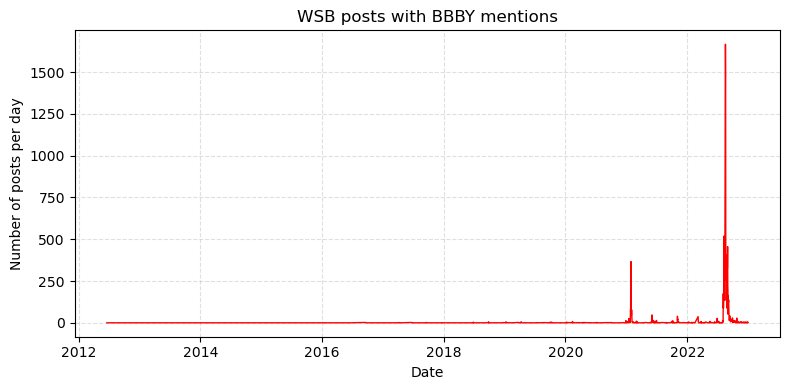

In [38]:
# Plot number of posts
plt.figure(figsize=(8, 4))
plt.plot(posts_number['date'], posts_number['post_count'], marker='', linestyle='-', color='red', linewidth=1)
plt.title('WSB posts with BBBY mentions')
plt.xlabel('Date')
plt.ylabel('Number of posts per day')
plt.tight_layout()
ax = plt.gca()
ax.grid(True, linestyle='--', alpha=0.4)
plt.show();

In [18]:
# Check the share of posts from 2021 onwards
posts2021 = posts_number[posts_number['date']>= datetime(2021, 1, 1).date()]
print('Share of post published after 2021 in total number of posts:', 
      round(posts2021['post_count'].sum()/posts_number['post_count'].sum()*100, 2),'%') 

Share of post published after 2021 in total number of posts: 98.07 %


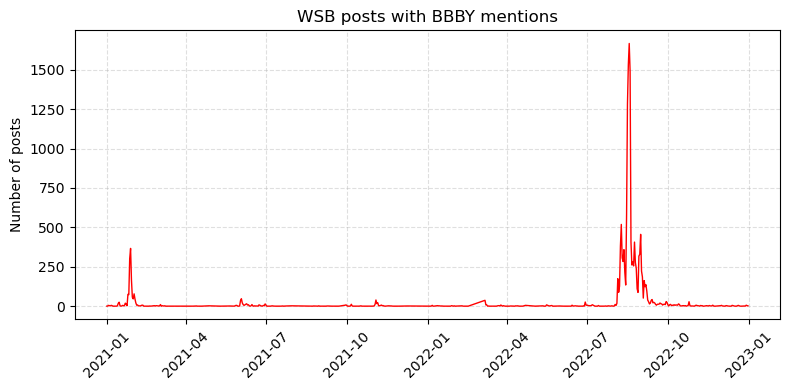

In [19]:
# Plot number of posts (01.01.2021 - 31.12.2022)
plt.figure(figsize=(8, 4))
plt.plot(posts2021['date'], posts2021['post_count'], marker='', linestyle='-', color='red', linewidth=1)
plt.title('WSB posts with BBBY mentions')
plt.ylabel('Number of posts')

ax = plt.gca()
ax.grid(True, linestyle='--', alpha=0.4)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Retrieve share price dynamics
# define the ticker for GameStop
stock_symbol = "BBBYQ"

# define the start and end dates
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 12, 31)

#retrieve the data
bbby_prices = yf.download(stock_symbol, start=start_date, end=end_date).reset_index()
bbby_prices.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,17.969999,18.590000,17.700001,18.030001,18.030001,13984900
1,2021-01-05,18.030001,19.889999,17.930000,19.760000,19.760000,13674400
2,2021-01-06,20.260000,21.570000,20.160000,21.030001,21.030001,19065700
3,2021-01-07,17.940001,19.580000,17.750000,18.730000,18.730000,37425800
4,2021-01-08,19.350000,19.520000,18.740000,18.940001,18.940001,11213800


In [21]:
# Compute daily relative change, r(t) = p(t)/p(t-1), where p(t) is the Open price at day t.
bbby_prices['daily_change'] = (bbby_prices['Open'] / bbby_prices['Open'].shift(1) - 1)*100
bbby_prices['Date'] = pd.to_datetime(bbby_prices['Date'])
bbby_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily_change
0,2021-01-04,17.969999,18.590000,17.700001,18.030001,18.030001,13984900,NaN
1,2021-01-05,18.030001,19.889999,17.930000,19.760000,19.760000,13674400,0.333897
2,2021-01-06,20.260000,21.570000,20.160000,21.030001,21.030001,19065700,12.368272
3,2021-01-07,17.940001,19.580000,17.750000,18.730000,18.730000,37425800,-11.451134
4,2021-01-08,19.350000,19.520000,18.740000,18.940001,18.940001,11213800,7.859531


In [22]:
# Save to csv 
bbby_prices.to_csv('bbby_prices.csv')

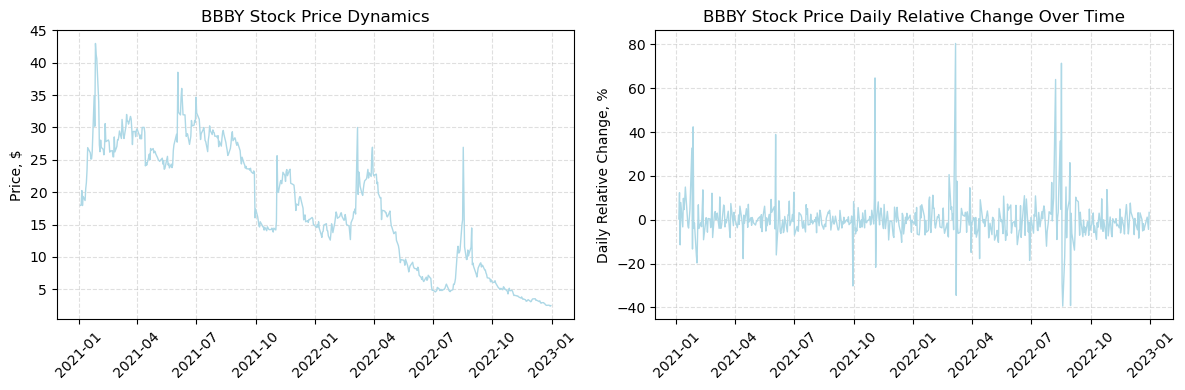

In [23]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize as needed

# Plot the first subplot (left)
axes[0].plot(bbby_prices['Date'], bbby_prices['Open'], marker='', linestyle='-', color='lightblue', linewidth=1)
axes[0].set_title('BBBY Stock Price Dynamics')
axes[0].set_ylabel('Price, $')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.4)

# Plot the second subplot (right)
axes[1].plot(bbby_prices['Date'], bbby_prices['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)
axes[1].set_title('BBBY Stock Price Daily Relative Change Over Time')
axes[1].set_ylabel('Daily Relative Change, %')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.4)

# Add space between subplots
plt.tight_layout()

# Show the combined figure with both subplots
plt.show()

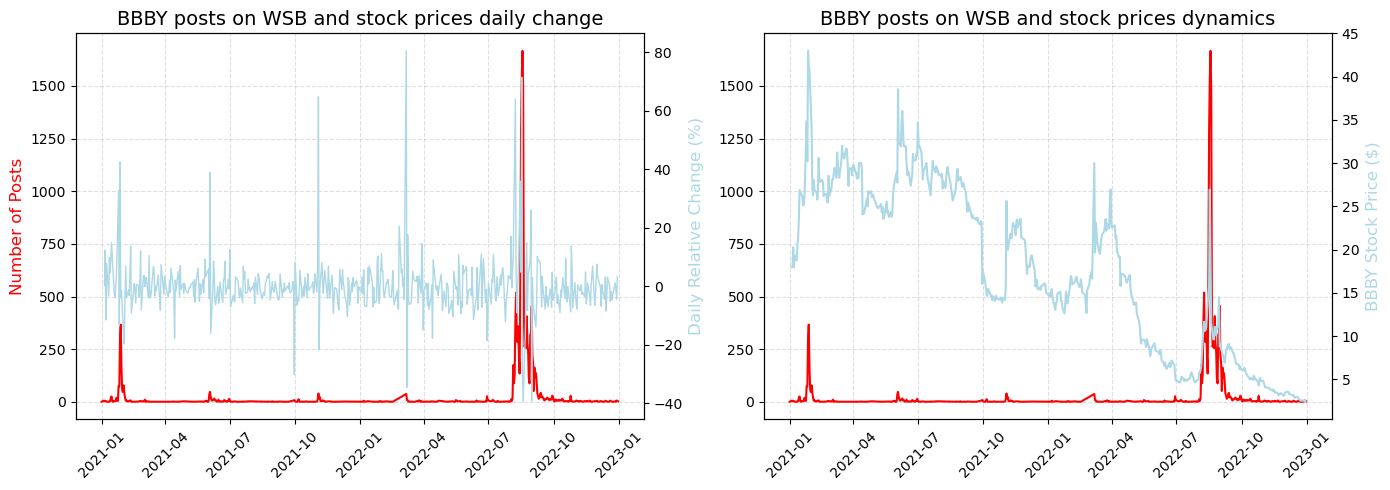

In [24]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Adjust the figsize as needed

# Plot 1: WSB posts with BBBY mentions and BBBY stock prices dynamics
# Increase line width and add grid lines
ax1.plot(posts2021['date'], posts2021['post_count'], marker='', linestyle='-', color='red', linewidth=1.5)
ax1.grid(True, linestyle='--', alpha=0.4)

# Create a second axis sharing the same x-axis
ax1_2 = ax1.twinx()

# Plot bbby stock prices on the second axis
ax1_2.plot(bbby_prices['Date'], bbby_prices['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)

# Set titles and labels for Plot 1
ax1.set_title('BBBY posts on WSB and stock prices daily change', fontsize=14)
ax1.set_ylabel('Number of Posts', color='red', fontsize=12)
ax1_2.set_ylabel('Daily Relative Change (%)', color='lightblue', fontsize=12)

# Plot 2: WSB posts with BBBY mentions and BBBY stock prices dynamics
# Increase line width and add grid lines
ax2.plot(posts2021['date'], posts2021['post_count'], marker='', linestyle='-', color='red', linewidth=1.5)
ax2.grid(True, linestyle='--', alpha=0.4)

# Create a second axis sharing the same x-axis
ax2_2 = ax2.twinx()

# Plot bbby stock prices on the second axis
ax2_2.plot(bbby_prices['Date'], bbby_prices['Open'], marker='', linestyle='-', color='lightblue', linewidth=1.5)

# Set titles and labels for Plot 2
ax2.set_title('BBBY posts on WSB and stock prices dynamics', fontsize=14)
ax2_2.set_ylabel('BBBY Stock Price ($)', color='lightblue', fontsize=12)

# Rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

# Ensure proper spacing and display the subplots
plt.tight_layout()
plt.show()


### Google trends analysis

In [28]:
# Open csv file with Google Trends data for 'Bed Bath & Beyond Inc.' search
google_trends = pd.read_csv('bed_bath_google.csv')[1:].reset_index()
google_trends = google_trends.rename(columns={'index': 'week', 'Category: All categories': 'interest'})
google_trends['week'] = pd.to_datetime(google_trends['week'], format='%Y-%m-%d')
google_trends['interest'] = google_trends['interest'].astype('int')
google_trends.head()

,week,interest
0,2021-01-03,80
1,2021-01-10,72
2,2021-01-17,73
3,2021-01-24,74
4,2021-01-31,60


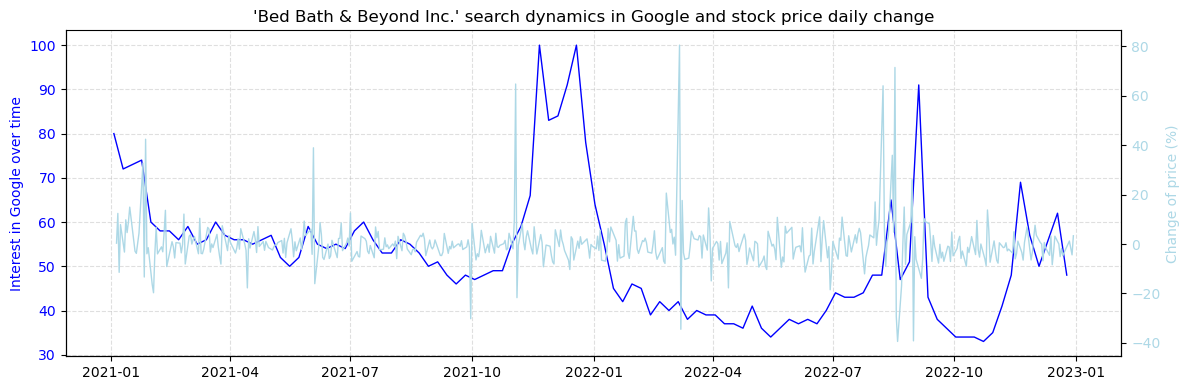

In [29]:
# Create a figure 
fig, ax1 = plt.subplots(figsize=(12, 4))  # Adjust the figure size as needed

# Plot number of posts on the first axis
ax1.plot(google_trends['week'], google_trends['interest'], marker='', linestyle='-', color='blue', linewidth=1)
ax1.set_ylabel('Interest in Google over time', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
#ax1.spines['top'].set_color('none')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot bbby stock prices on the second axis
ax2.plot(bbby_prices['Date'], bbby_prices['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax2.set_ylabel('Change of price (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')
ax2.spines['top'].set_color('none')

# Set titles for both plots
ax1.set_title('\'Bed Bath & Beyond Inc.\' search dynamics in Google and stock price daily change')
ax1.grid(True, linestyle='--', alpha=0.4)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show();

In [32]:
# Open csv file with Google Trends data for 'BBBY' search
google_trends_bbby = pd.read_csv('bbby_google.csv')[1:].reset_index()
google_trends_bbby = google_trends_bbby.rename(columns={'index': 'week', 'Category: All categories': 'interest'})
google_trends_bbby['week'] = pd.to_datetime(google_trends_bbby['week'], format='%Y-%m-%d')
# Replace non-integer values in the 'interest' column with 0
google_trends_bbby['interest'] = google_trends_bbby['interest'].apply(lambda x: 0 if '<' in str(x) else int(x))
# converting the 'interest' column to integers
google_trends_bbby['interest'] = google_trends_bbby['interest'].astype('int')

google_trends_bbby.head()

,week,interest
0,2021-01-03,2
1,2021-01-10,2
2,2021-01-17,1
3,2021-01-24,17
4,2021-01-31,5


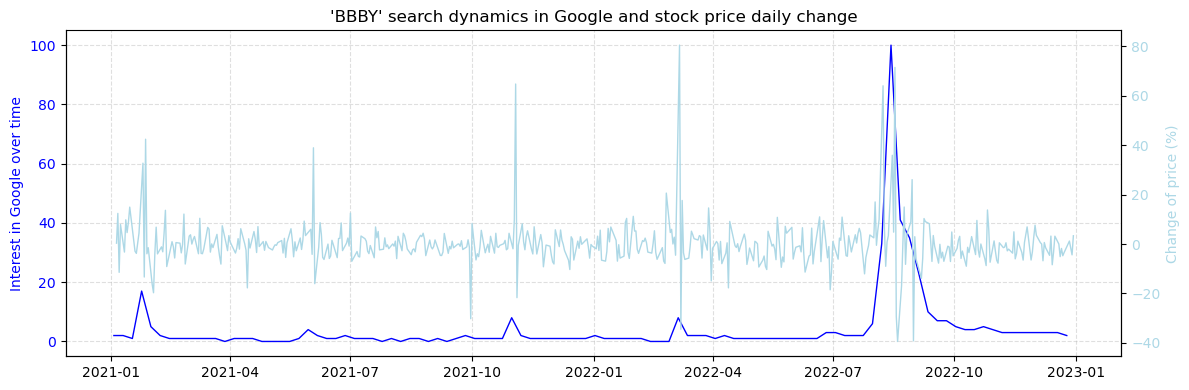

In [33]:
# Create a figure 
fig, ax1 = plt.subplots(figsize=(12, 4))  # Adjust the figure size as needed

# Plot number of posts on the first axis
ax1.plot(google_trends_bbby['week'], google_trends_bbby['interest'], marker='', linestyle='-', color='blue', linewidth=1)
ax1.set_ylabel('Interest in Google over time', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
#ax1.spines['top'].set_color('none')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot bbby stock prices on the second axis
ax2.plot(bbby_prices['Date'], bbby_prices['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax2.set_ylabel('Change of price (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')
ax2.spines['top'].set_color('none')

# Set titles for both plots
ax1.set_title('\'BBBY\' search dynamics in Google and stock price daily change')
ax1.grid(True, linestyle='--', alpha=0.4)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show();

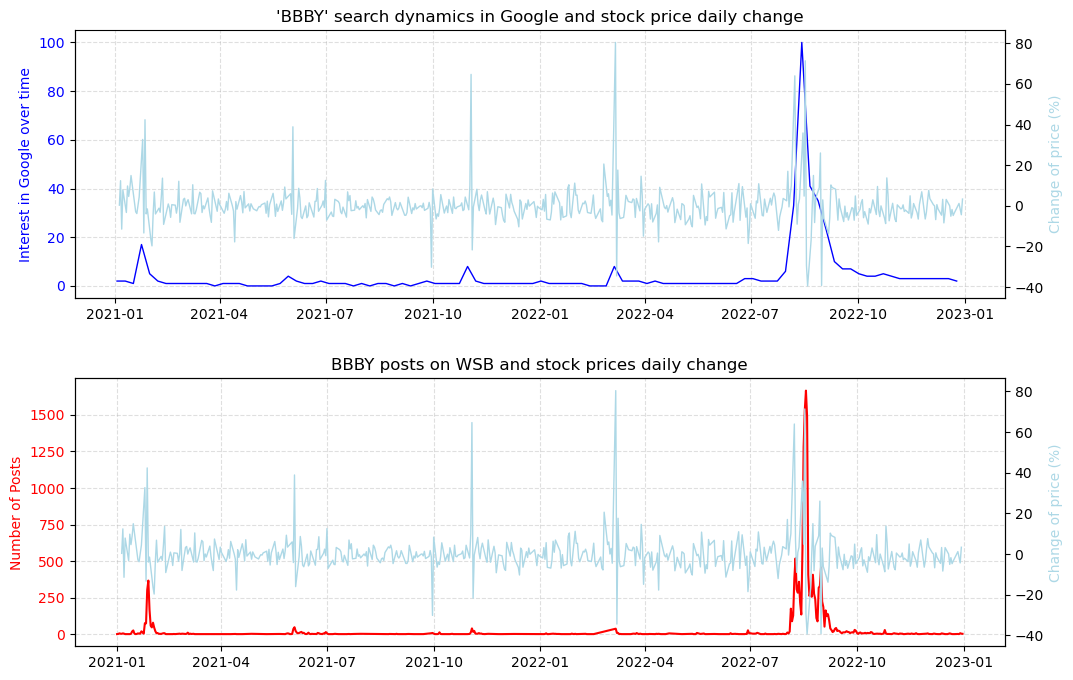

In [37]:
# Create a figure with two subplots (2 rows, 1 column) to compare plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.3})  # Adjust the figsize as needed

# Plot 1: Google Trends and BBBY stock price
ax1.plot(google_trends_bbby['week'], google_trends_bbby['interest'], marker='', linestyle='-', color='blue', linewidth=1)
ax1.set_ylabel('Interest in Google over time', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_2 = ax1.twinx()
ax1_2.plot(bbby_prices['Date'], bbby_prices['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax1_2.set_ylabel('Change of price (%)', color='lightblue')
ax1_2.spines['top'].set_color('none')

ax1.set_title('\'BBBY\' search dynamics in Google and stock price daily change')
ax1.grid(True, linestyle='--', alpha=0.4)

# Plot 2: WSB posts and BBBY stock price
ax2.plot(posts2021['date'], posts2021['post_count'], marker='', linestyle='-', color='red', linewidth=1.5)
ax2.grid(True, linestyle='--', alpha=0.4)

ax2_2 = ax2.twinx()
ax2_2.plot(bbby_prices['Date'], bbby_prices['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)

ax2.set_title('BBBY posts on WSB and stock prices daily change')
ax2.set_ylabel('Number of Posts', color='red')
ax2_2.set_ylabel('Change of price (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()

In [131]:
# News search dynamics comparison 
news = pd.read_csv('news_search.csv')[1:].reset_index()
news = news.rename(columns={'level_0': 'week', 'level_1': 'Bed Bath and Beyond', 'Category: All categories': 'BBBY'})
news['week'] = pd.to_datetime(news['week'], format='%Y-%m-%d')
news['Bed Bath and Beyond'] = news['Bed Bath and Beyond'].astype('int')
news['BBBY'] = news['BBBY'].astype('int')
news.head()

,week,Bed Bath and Beyond,BBBY
0,2021-01-03,9,0
1,2021-01-10,10,0
2,2021-01-17,10,0
3,2021-01-24,14,7
4,2021-01-31,10,6


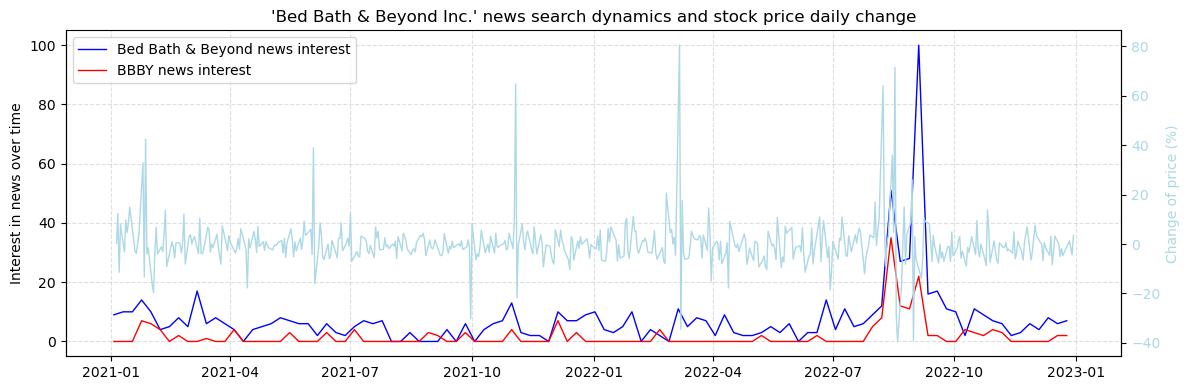

In [133]:
# Create a figure
fig, ax1 = plt.subplots(figsize=(12, 4))  # Adjust the figure size as needed

# Plot number of posts on the first axis
line1, = ax1.plot(news['week'], news['Bed Bath and Beyond'], marker='', linestyle='-', color='blue', linewidth=1)
line2, = ax1.plot(news['week'], news['BBBY'], marker='', linestyle='-', color='red', linewidth=1)  # Added line

ax1.set_ylabel('Interest in news over time')
ax1.tick_params(axis='y')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot bbby stock prices on the second axis
ax2.plot(bbby_prices['Date'], bbby_prices['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax2.set_ylabel('Change of price (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')
ax2.spines['top'].set_color('none')

# Set titles for both plots
ax1.set_title('\'Bed Bath & Beyond Inc.\' news search dynamics and stock price daily change')

# Create a custom legend
handles = [line1, line2]
labels = ['Bed Bath & Beyond news interest', 'BBBY news interest']

# Add the legend with custom handles and labels
ax1.legend(handles, labels, loc='upper left')

ax1.grid(True, linestyle='--', alpha=0.4)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show()

### Time frame 01.08.2022-15.09.2022

In [39]:
# Select Time frame 01.08.2022-15.09.2022
start_date = datetime(2022, 8, 1)
end_date = datetime(2022, 9, 15)

posts2022 = posts_number[(posts_number['date'] >= start_date.date()) & (posts_number['date'] <= end_date.date())]
bbby_prices2022 = bbby_prices[(bbby_prices['Date'] >= start_date) & (bbby_prices['Date'] <= end_date)]

print('Share of post published in 01.08.2022-15.09.2022:', 
      round(posts2022['post_count'].sum()/posts_number['post_count'].sum()*100, 2),'%') 

Share of post published in 01.08.2022-15.09.2022: 81.34 %


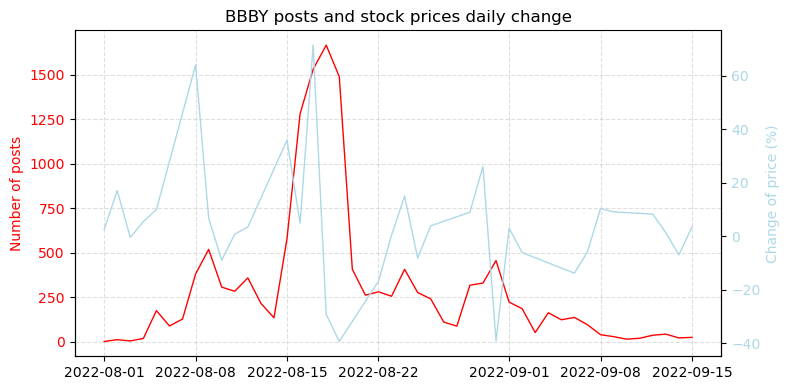

In [41]:
# Create a figure 
fig, ax1 = plt.subplots(figsize=(8, 4))  # Adjust the figure size as needed

# Plot number of posts on the first axis
ax1.plot(posts2022['date'], posts2022['post_count'], marker='', linestyle='-', color='red', linewidth=1)
ax1.set_ylabel('Number of posts', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot bbby stock prices on the second axis
ax2.plot(bbby_prices2022['Date'], bbby_prices2022['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax2.set_ylabel('Change of price (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')
ax2.spines['top'].set_color('none')

# Set titles for both plots
ax1.set_title('BBBY posts and stock prices daily change')
ax1.grid(True, linestyle='--', alpha=0.4)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show();


### 2.2. Number of posts on WSB that showed financial commitment (flairs)

In [42]:
# Check all unique flairs 
unique_flairs = set()

for post in posts:
    author_flair = post.get('link_flair_css_class')
    if author_flair is not None:
        unique_flairs.add(author_flair)

unique_flairs

{'',
 'chart',
 'conspiracy',
 'dd',
 'donation',
 'earnings',
 'fundamentals',
 'futures',
 'loss',
 'meme',
 'news',
 'options',
 'profit',
 'question',
 'shitpost',
 'stocks',
 'storytime',
 'technicals',
 'yolo'}

In [199]:
# Check flair marks in posts: profit, loss, YOLO in link_flair_css_class
flair_counts = {'profit': 0, 'loss': 0, 'yolo': 0}

# Iterate through the data entries
for entry in posts:
    author_flair = entry.get('link_flair_css_class')
    if author_flair in flair_counts:
        flair_counts[author_flair] += 1

# Print the counts for each flair
for flair, count in flair_counts.items():
    print(f"{flair}: {count} posts")

profit: 735 posts
loss: 415 posts
yolo: 1999 posts


In [207]:
#Count of posts by flare and date
# Filter rows to include only the flair classes you're interested in
flairs = posts_df[posts_df['link_flair_css_class'].isin(['profit', 'loss', 'yolo'])]

# Filter the DataFrame 
flairs = flairs[(flairs['date'] >= start_date.date()) & (flairs['date'] <= end_date.date())]

# Group the data by 'created_utc' and 'link_flair_css_class' and count the number of occurrences
flairs = flairs.groupby(['date', 'link_flair_css_class']).size().reset_index(name='count')

# Pivot the DataFrame so that 'link_flair_css_class' values become columns
flairs = flairs.pivot(index='date', columns='link_flair_css_class', values='count').fillna(0)

In [208]:
# count total number of flairs
flairs.columns = {'loss', 'profit', 'yolo'}
flairs['total'] = flairs['loss'] + flairs['profit'] + flairs['yolo']
flairs.head()

,yolo,loss,profit,total
date,,,,
2022-08-01,0.0,0.0,1.0,1.0
2022-08-02,0.0,0.0,2.0,2.0
2022-08-04,3.0,1.0,2.0,6.0
2022-08-05,4.0,30.0,44.0,78.0
2022-08-06,1.0,6.0,26.0,33.0


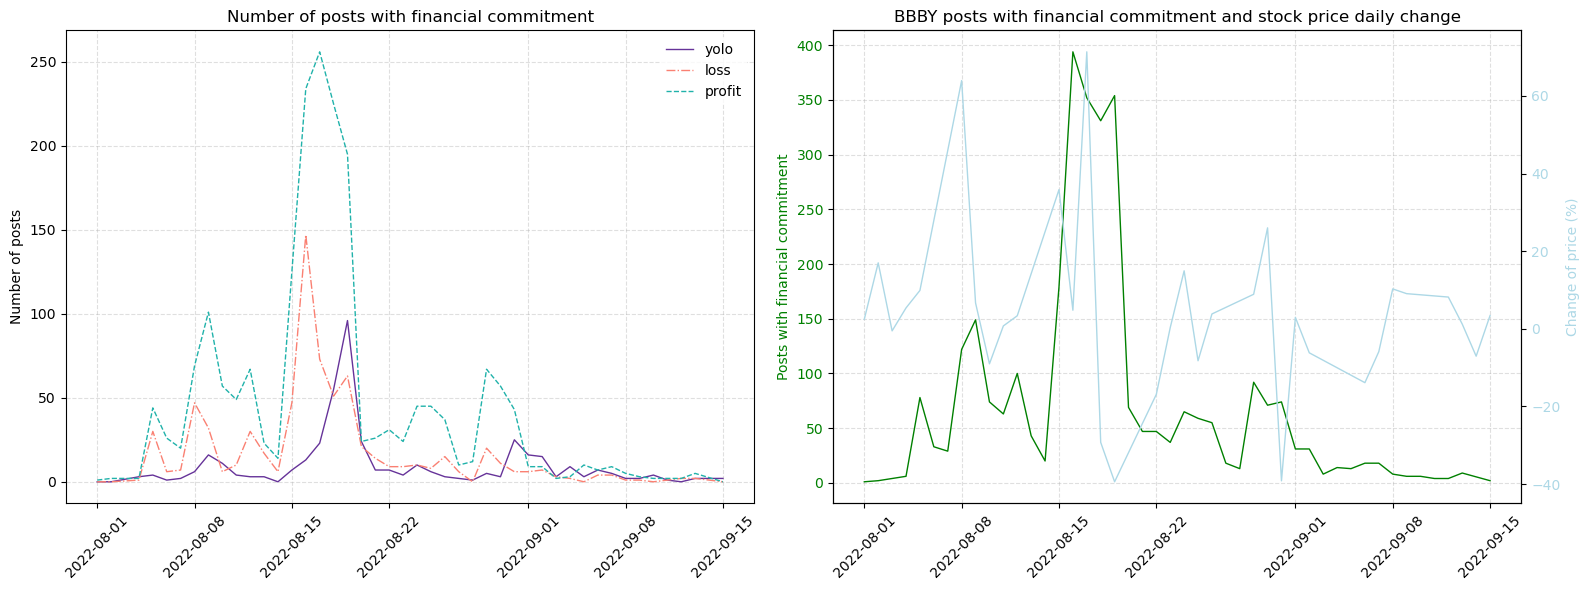

In [212]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create two subplots side by side

# Plotting the first three columns on the first subplot
colors = {
    'profit': 'lightseagreen',
    'loss': 'salmon',
    'yolo': 'rebeccapurple'
}

linestyle = {
    'profit': '--',
    'loss': '-.',
    'yolo': '-'
}

# Plot each line on the first subplot
for column in flairs.iloc[:, :3].columns:  # Select the first three columns
    ax1.plot(flairs.index, flairs[column], label=column, color=colors[column], linestyle=linestyle[column], linewidth=1)

ax1.set_title('Number of posts with financial commitment')
ax1.set_ylabel('Number of posts')

# Get the current axis
legend1 = ax1.legend(fancybox=False, shadow=False)

# Remove the legend border on the first subplot
legend1.get_frame().set_linewidth(0.0)

ax1.grid(True, linestyle='--', alpha=0.4)

# Plot total number of flairs on the second subplot
ax2.plot(flairs.index, flairs['total'], marker='', linestyle='-', color='green', linewidth=1)
ax2.set_ylabel('Posts with financial commitment', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a second axis sharing the same x-axis
ax2_twin = ax2.twinx()

# Plot bbby stock prices on the second axis of the second subplot
ax2_twin.plot(bbby_prices2022['Date'], bbby_prices2022['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax2_twin.set_ylabel('Change of price (%)', color='lightblue')
ax2_twin.tick_params(axis='y', labelcolor='lightblue')

# Set titles for both subplots
ax2.set_title('BBBY posts with financial commitment and stock price daily change')
ax2.grid(True, linestyle='--', alpha=0.4)

# Rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show()

### 2.3 Group identity 

In [48]:
# Count occurrences of 'we' and 'I' in selftext
pattern = r'\bI\b'

for entry in posts:
    selftext = entry.get('selftext', '')  # Default to an empty string if selftext is not present

    # Tokenize the selftext using the regular expression pattern
    tokens = re.findall(pattern, selftext, flags=re.IGNORECASE)

    # Count occurrences of 'we' and 'I'
    we_count = selftext.lower().count('we')
    i_count = len(tokens)

    entry['we_n'] = we_count
    entry['I_n'] = i_count

    # Set we_n and I_n to 0 if no occurrences are found
    if we_count == 0:
        entry['we_n'] = 0
    if i_count == 0:
        entry['I_n'] = 0


    if entry['we_n'] + entry['I_n'] != 0:
        entry['identity'] = entry['we_n'] / (entry['we_n'] + entry['I_n'])
    else:
        entry['identity'] = 0

In [49]:
# Check the number 
identity_not_null = 0

for entry in posts:
    if entry['identity'] > 0:
        identity_not_null += 1

identity_not_null

1868

In [50]:
# Count per date 
date_identity_totals = {}
date_identity_counts = {}

for entry in posts:
    date = entry.get('date')
    identity = entry.get('identity')

    if date is not None and identity is not None:
        if date not in date_identity_totals:
            date_identity_totals[date] = 0
            date_identity_counts[date] = 0

        date_identity_totals[date] += identity
        date_identity_counts[date] += 1

In [51]:
average_identity_data = [{'date': date, 'average_identity': total / count}
                         for date in date_identity_totals.keys()
                         for total, count in [(date_identity_totals[date], date_identity_counts[date])]
                         if count > 0]

In [52]:
average_identity_df = pd.DataFrame(average_identity_data)
average_identity_df.head()

,date,average_identity
0,2012-06-19,0.000000
1,2013-04-08,0.333333
2,2014-06-27,1.000000
3,2015-01-05,0.000000
4,2015-04-03,0.384615


In [53]:
# Filter the DataFrame to include data within the specified time frame
average_identity_df = average_identity_df[(average_identity_df['date'] >= start_date.date()) & (average_identity_df['date'] < end_date.date())]

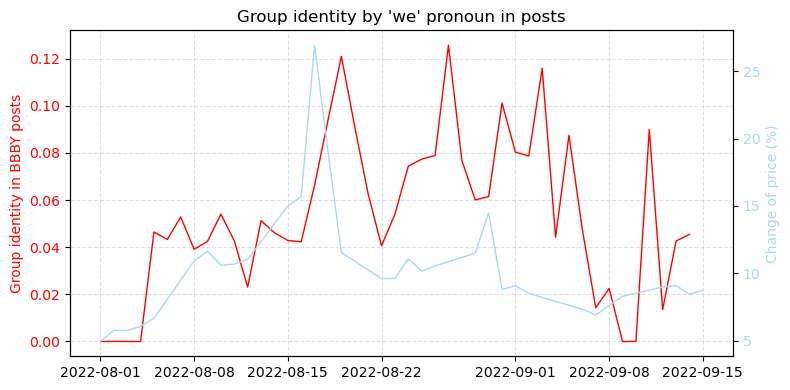

In [54]:
# Plot total number of flairs 
fig, ax1 = plt.subplots(figsize=(8, 4))  # Adjust the figure size as needed

# Plot number of posts on the first axis
ax1.plot(average_identity_df['date'], average_identity_df['average_identity'], marker='',
         linestyle='-', color='red', linewidth=1)
ax1.set_ylabel('Group identity in BBBY posts', color='red')
ax1.tick_params(axis='y', labelcolor='red')
# Remove the top spine by setting their color and linewidth to 'none'

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot bbby stock prices on the second axis
ax2.plot(bbby_prices2022['Date'], bbby_prices2022['Open'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax2.set_ylabel('Change of price (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')

# Set titles for both plots
ax1.set_title('Group identity by \'we\' pronoun in posts')
ax1.grid(True, linestyle='--', alpha=0.4)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show();

In [55]:
# Measure group identity by posts awards
awards = []

for post in posts:
    data = {}
    if 'all_awardings' in post and post['all_awardings']:
        if len(post['all_awardings']) != 0:
            data['time'] = post['created_utc']
            count = 0
            for awardings in post['all_awardings']:
                price = awardings['count']
                count += price
            data['price'] = count
            awards.append(data)

award = pd.DataFrame(awards)
award['date'] = pd.to_datetime(award['time'])
award['date'] = pd.to_datetime(award['date']).dt.date

# Group by date and count mean number of awards per post
pivot = award.groupby('date')['price'].mean()
pivot = pd.DataFrame(pivot).reset_index()

# Failter the DataFrame to include data within the specified time frame
pivot = pivot[(pivot['date'] >= start_date.date()) & (pivot['date'] < end_date.date())]
pivot.head()

,date,price
111,2022-08-02,1.000000
112,2022-08-03,3.000000
113,2022-08-04,48.250000
114,2022-08-05,5.186047
115,2022-08-06,5.250000


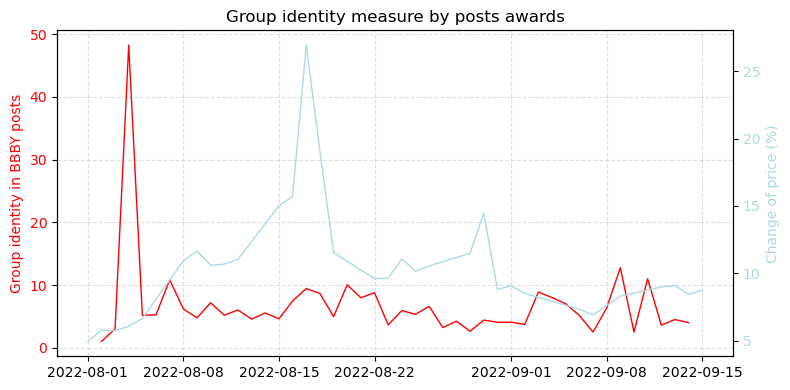

In [56]:
# Plot total number of flairs 
fig, ax1 = plt.subplots(figsize=(8, 4))  # Adjust the figure size as needed

# Plot number of posts on the first axis
ax1.plot(pivot['date'], pivot['price'], marker='',
         linestyle='-', color='red', linewidth=1)
ax1.set_ylabel('Group identity in BBBY posts', color='red')
ax1.tick_params(axis='y', labelcolor='red')
# Remove the top spine by setting their color and linewidth to 'none'

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot bbby stock prices on the second axis
ax2.plot(bbby_prices2022['Date'], bbby_prices2022['Open'], marker='', linestyle='-', color='lightblue', linewidth=1)
ax2.set_ylabel('Change of price (%)', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')

# Set titles for both plots
ax1.set_title('Group identity measure by posts awards')
ax1.grid(True, linestyle='--', alpha=0.4)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show();

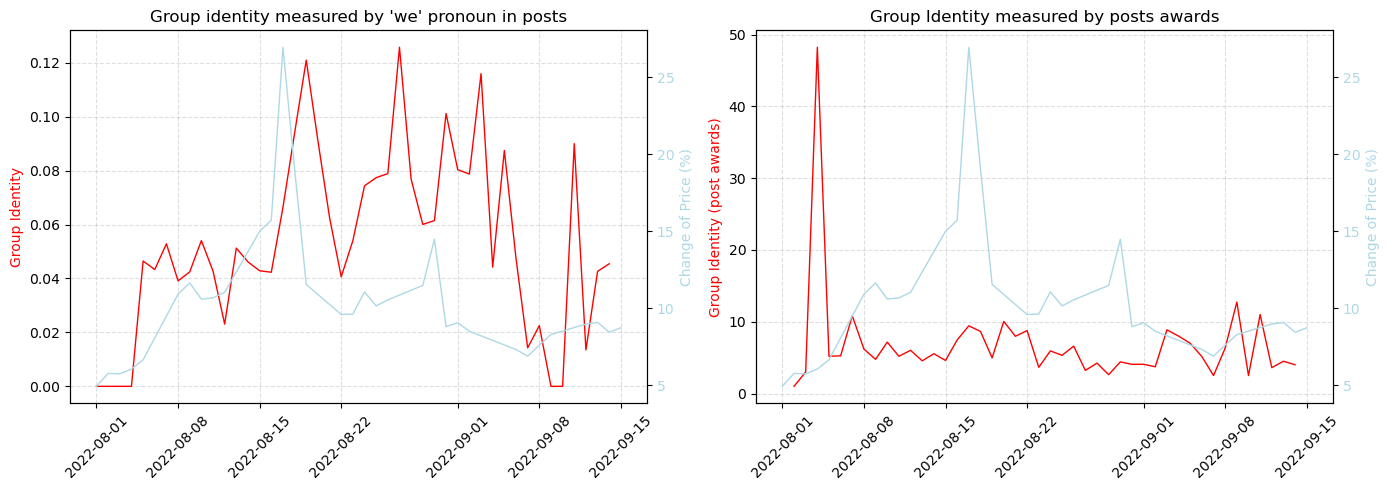

In [59]:
import matplotlib.pyplot as plt

# Create a figure with two subplots in one row and two columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Group identity in BBBY posts
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.plot(average_identity_df['date'], average_identity_df['average_identity'], marker='',
          linestyle='-', color='red', linewidth=1)
ax1.set_title('Group identity measured by \'we\' pronoun in posts')
ax1.set_ylabel('Group Identity', color = 'red')

# Create a second axis sharing the same x-axis
ax1_2 = ax1.twinx()

# Plot bbby stock prices on the second axis of the first subplot
ax1_2.plot(bbby_prices2022['Date'], bbby_prices2022['Open'], marker='',
            linestyle='-', color='lightblue', linewidth=1)
ax1_2.set_ylabel('Change of Price (%)', color='lightblue')
ax1_2.tick_params(axis='y', labelcolor='lightblue')

# Plot 2: Group identity measured by posts awards
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.plot(pivot['date'], pivot['price'], marker='',
          linestyle='-', color='red', linewidth=1)
ax2.set_title('Group Identity measured by posts awards')
ax2.set_ylabel('Group Identity (post awards)', color = 'red')

# Create a second axis sharing the same x-axis
ax2_2 = ax2.twinx()

# Plot bbby stock prices on the second axis of the second subplot
ax2_2.plot(bbby_prices2022['Date'], bbby_prices2022['Open'], marker='',
            linestyle='-', color='lightblue', linewidth=1)
ax2_2.set_ylabel('Change of Price (%)', color='lightblue')
ax2_2.tick_params(axis='y', labelcolor='lightblue')

# Rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

# Ensure proper spacing and display the subplots
plt.tight_layout()
plt.show();

## 3. Sentiment analysis

### 3.1. Posts sentiment

In [60]:
# Create the df for sentiment analysis 
posts_sentiment = posts_df[(posts_df['date'] >= start_date.date()) & 
                           (posts_df['date'] <= end_date.date())][['date', 'selftext']].copy()

In [61]:
# delete posts with emty selftext
posts_sentiment.drop(posts_sentiment[posts_sentiment['selftext'].str.contains(r'\[removed\]|\[deleted\]')].index, inplace=True)
posts_sentiment = posts_sentiment[~posts_sentiment['selftext'].str.strip().eq('')]
posts_sentiment.head()

,date,selftext
2633,2022-08-04,I’m hearing BBBY is about to take off and is o...
2636,2022-08-04,I also have another account with more $BBBY. ...
2654,2022-08-05,"Alright tards,\n\nI'd say that it's pretty saf..."
2657,2022-08-05,$BBBY$ is in the same situation as GameStop. B...
2661,2022-08-05,Did I miss something? What happened with Musk ...


In [62]:
analyzer = SentimentIntensityAnalyzer()

# apply sentiment analysis and create 'VADER_compound' column 
posts_sentiment['VADER_compound'] = posts_sentiment['selftext'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# function to apply sentiment analysis and extract sentiment class
def get_sentiment_class(compound_score):
    if compound_score > 0.5:
        return "Positive"
    elif compound_score < -0.5:
        return "Negative"
    else:
        return "Neutral"

# create 'VADER_class' column 
posts_sentiment['VADER_class'] = posts_sentiment['VADER_compound'].apply(get_sentiment_class)

# Save result to csv 
posts_sentiment.to_csv('posts_sentiment.csv')

In [63]:
posts_sentiment.head()

,date,selftext,VADER_compound,VADER_class
2633,2022-08-04,I’m hearing BBBY is about to take off and is o...,0.5719,Positive
2636,2022-08-04,I also have another account with more $BBBY. ...,0.0000,Neutral
2654,2022-08-05,"Alright tards,\n\nI'd say that it's pretty saf...",0.9843,Positive
2657,2022-08-05,$BBBY$ is in the same situation as GameStop. B...,-0.5574,Negative
2661,2022-08-05,Did I miss something? What happened with Musk ...,-0.3736,Neutral


In [64]:
posts_sentiment_groupped = posts_sentiment.groupby('date')['VADER_compound'].mean().reset_index()

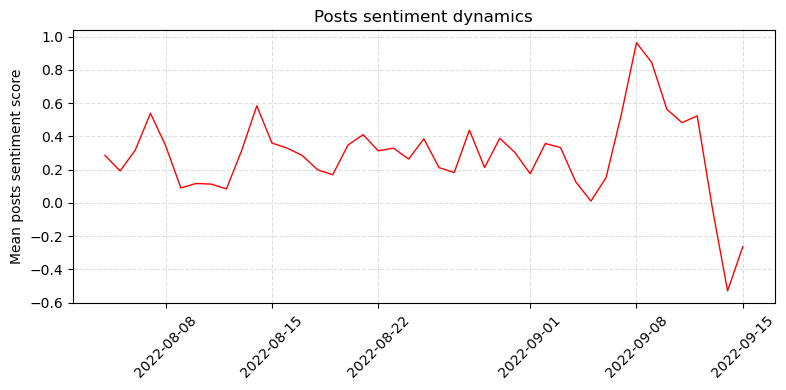

In [65]:
# Plot number of posts (01.01.2021 - 31.12.2022)
plt.figure(figsize=(8, 4))
ax = plt.gca()
ax.grid(True, linestyle='--', alpha=0.4)
plt.plot(posts_sentiment_groupped['date'], posts_sentiment_groupped['VADER_compound'], marker='', linestyle='-', color='red', linewidth=1)
plt.title('Posts sentiment dynamics')
plt.ylabel('Mean posts sentiment score')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [66]:
sentiment_pivot = pd.pivot_table(posts_sentiment[['date', 'VADER_compound', 'VADER_class']], index='date', columns='VADER_class', aggfunc="count")
sentiment_pivot.columns = {'Negative', 'Neutral', 'Positive'}
sentiment_pivot.head()

,Neutral,Positive,Negative
date,,,
2022-08-04,NaN,1.0,1.0
2022-08-05,5.0,14.0,11.0
2022-08-06,3.0,5.0,7.0
2022-08-07,2.0,5.0,16.0
2022-08-08,6.0,23.0,31.0


### 3.2. Comments sentiment 

In [67]:
# convert posts JSON to DataFrame
sentiment_comments = pd.read_json('filtered_comments.json')

# create Date column 
sentiment_comments['Date'] = pd.to_datetime(sentiment_comments['created_utc'], unit='s').dt.date

In [68]:
# Filter the DataFrame 
sentiment_comments = sentiment_comments[(sentiment_comments['Date'] >= start_date.date()) & 
                           (sentiment_comments['Date'] <= end_date.date())][['Date', 'body']]

In [69]:
sentiment_comments.drop(sentiment_comments[sentiment_comments['body'].str.contains(r'\[removed\]|\[deleted\]')].index, inplace=True)
sentiment_comments = sentiment_comments[~sentiment_comments['body'].str.strip().eq('')]
sentiment_comments.head()

,Date,body
44293,2022-08-01,Ahem.
44294,2022-08-01,"Close. They do have some to do with that, but ..."
44295,2022-08-02,RemindMe! 30 days
44296,2022-08-02,I will be messaging you in 30 days on [**2022-...
44297,2022-08-02,Wow. Great conversation starter. You must be g...


In [70]:
# apply sentiment analysis and create 'VADER_compound' column 
sentiment_comments['VADER_compound'] = sentiment_comments['body'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# function to apply sentiment analysis and extract sentiment class
def get_sentiment_class(compound_score):
    if compound_score > 0.5:
        return "Positive"
    elif compound_score < -0.5:
        return "Negative"
    else:
        return "Neutral"

# create 'VADER_class' column 
sentiment_comments['VADER_class'] = sentiment_comments['VADER_compound'].apply(get_sentiment_class)

sentiment_comments.to_csv('comments_sentiment.csv')

In [71]:
# Group df by date 
sentiment_comments_groupped = sentiment_comments.groupby('Date')['VADER_compound'].mean().reset_index()

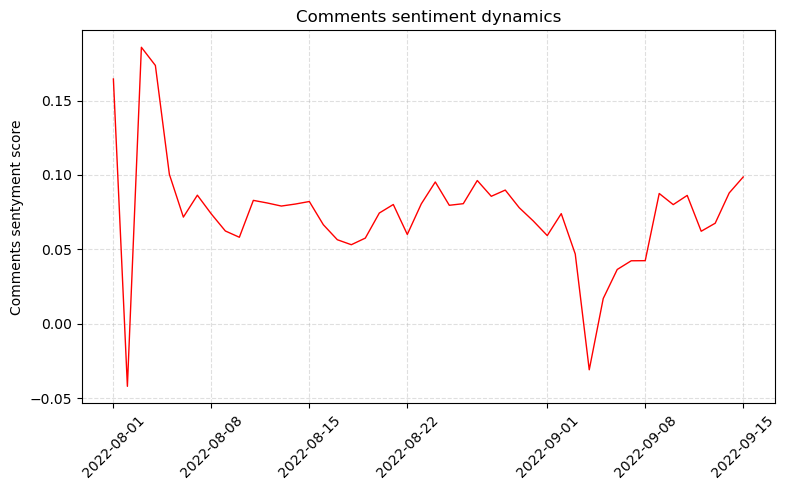

In [72]:
# Plot number of posts (01.01.2021 - 31.12.2022)
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.grid(True, linestyle='--', alpha=0.4)
plt.plot(sentiment_comments_groupped['Date'], sentiment_comments_groupped['VADER_compound'], marker='', linestyle='-', color='red', linewidth=1)
plt.title('Comments sentiment dynamics')
plt.ylabel('Comments sentyment score')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

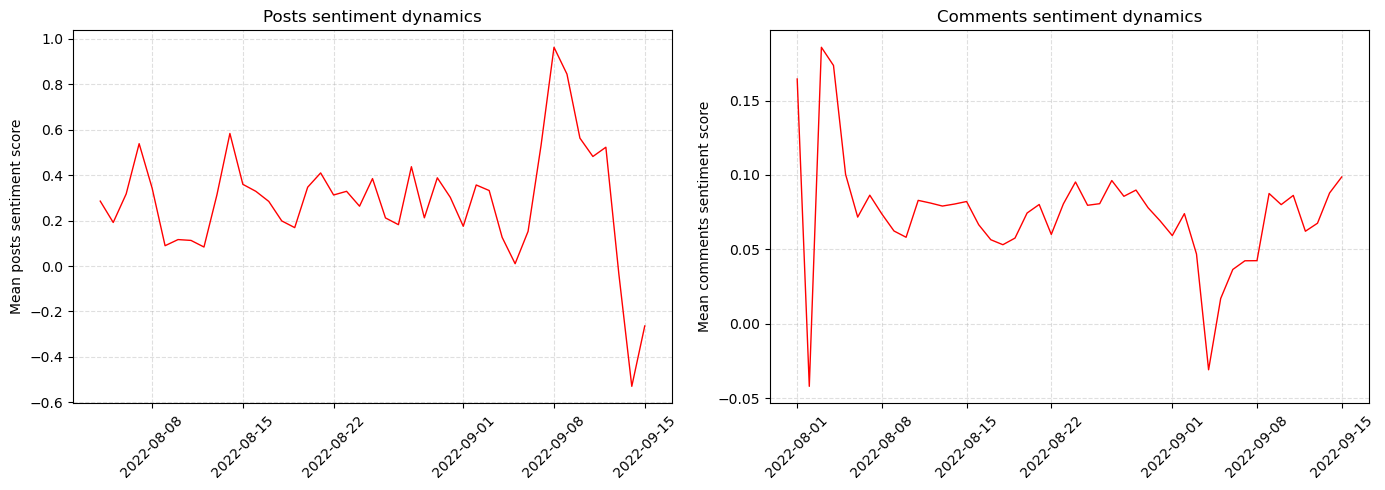

In [74]:
# Create a figure with two subplots 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Posts sentiment dynamics
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.plot(posts_sentiment_groupped['date'], posts_sentiment_groupped['VADER_compound'], marker='', linestyle='-', color='red', linewidth=1)
ax1.set_title('Posts sentiment dynamics')
ax1.set_ylabel('Mean posts sentiment score')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Comments sentiment dynamics
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.plot(sentiment_comments_groupped['Date'], sentiment_comments_groupped['VADER_compound'], marker='', linestyle='-', color='red', linewidth=1)
ax2.set_title('Comments sentiment dynamics')
ax2.set_ylabel('Mean comments sentiment score')
ax2.tick_params(axis='x', rotation=45)

# Ensure proper spacing and display the subplots
plt.tight_layout()
plt.show()


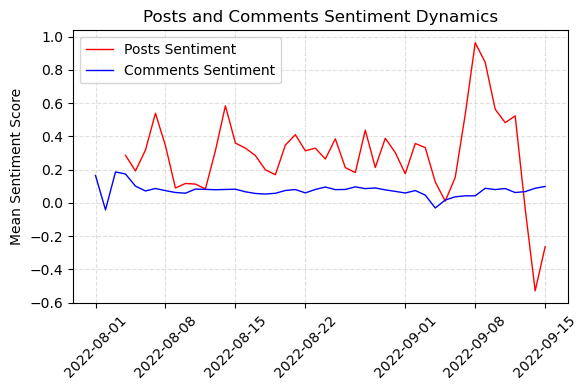

In [78]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot 1: Posts sentiment dynamics
ax.grid(True, linestyle='--', alpha=0.4)
ax.plot(posts_sentiment_groupped['date'], posts_sentiment_groupped['VADER_compound'], marker='', linestyle='-', color='red', linewidth=1, label='Posts Sentiment')

# Plot 2: Comments sentiment dynamics
ax.plot(sentiment_comments_groupped['Date'], sentiment_comments_groupped['VADER_compound'], marker='', linestyle='-', color='blue', linewidth=1, label='Comments Sentiment')

# Set titles and labels
ax.set_title('Posts and Comments Sentiment Dynamics')
ax.set_ylabel('Mean Sentiment Score')

# Add a legend
ax.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

# Ensure proper spacing and display the plot
plt.tight_layout()
plt.show()

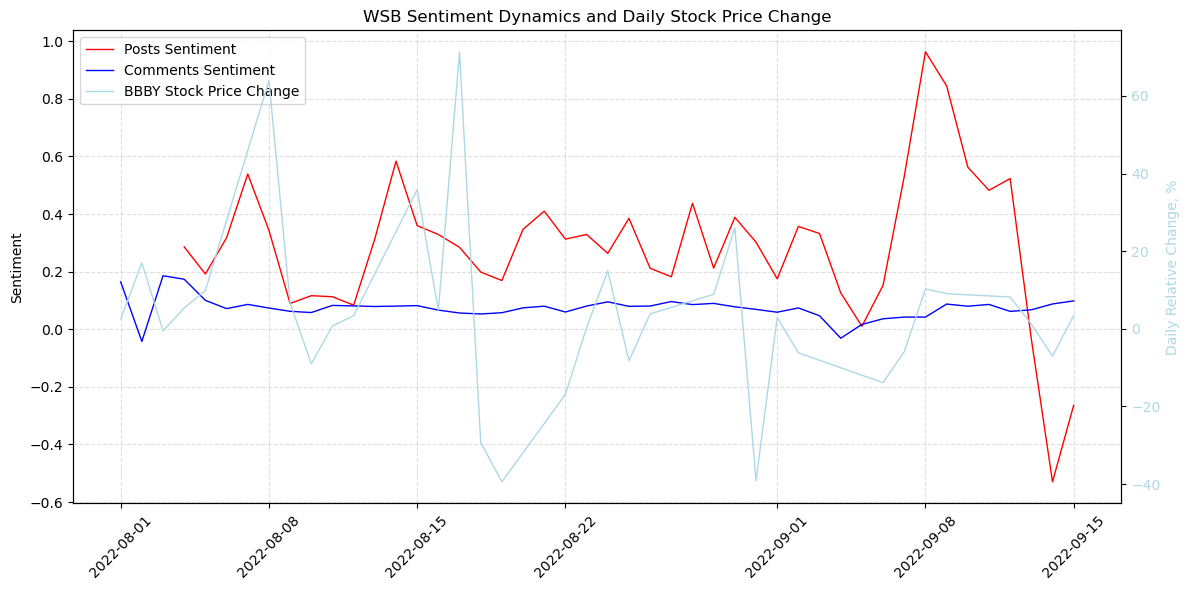

In [219]:
# Create a figure and the first axis for PLOT 1
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 1: Posts sentiment dynamics
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.plot(posts_sentiment_groupped['date'], posts_sentiment_groupped['VADER_compound'], marker='', linestyle='-', color='red', linewidth=1, label='Posts Sentiment')
ax1.plot(sentiment_comments_groupped['Date'], sentiment_comments_groupped['VADER_compound'], marker='', linestyle='-', color='blue', linewidth=1, label='Comments Sentiment')

# Set labels and title for the first y-axis (y1)
ax1.set_ylabel('Sentiment', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Add a legend for PLOT 1
lines_1, labels_1 = ax1.get_legend_handles_labels()

# Set the title for PLOT 1
ax1.set_title('WSB Sentiment Dynamics and Daily Stock Price Change')

# Create a second axis (y2) sharing the same x-axis for PLOT 2
ax2 = ax1.twinx()

# Plot 2: BBBY Stock Price Daily Relative Change
ax2.plot(bbby_prices2022['Date'], bbby_prices2022['daily_change'], marker='', linestyle='-', color='lightblue', linewidth=1, label='BBBY Stock Price Change')

# Set labels for the second y-axis (y2)
ax2.set_ylabel('Daily Relative Change, %', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')

# Add a legend for PLOT 2
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc='upper left')

# Rotate x-axis labels for PLOT 1
ax1.tick_params(axis='x', rotation=45)

# Add space between subplots
plt.tight_layout()

# Show the combined figure with both subplots
plt.show()


In [76]:
comments_sentiment_pivot = pd.pivot_table(sentiment_comments[['Date', 'VADER_compound', 'VADER_class']], index='Date', columns='VADER_class', aggfunc="count")
comments_sentiment_pivot.columns = {'Negative', 'Neutral', 'Positive'}
comments_sentiment_pivot.head()

,Neutral,Positive,Negative
Date,,,
2022-08-01,NaN,2.0,NaN
2022-08-02,11.0,7.0,5.0
2022-08-03,4.0,23.0,11.0
2022-08-04,19.0,188.0,57.0
2022-08-05,428.0,2992.0,731.0


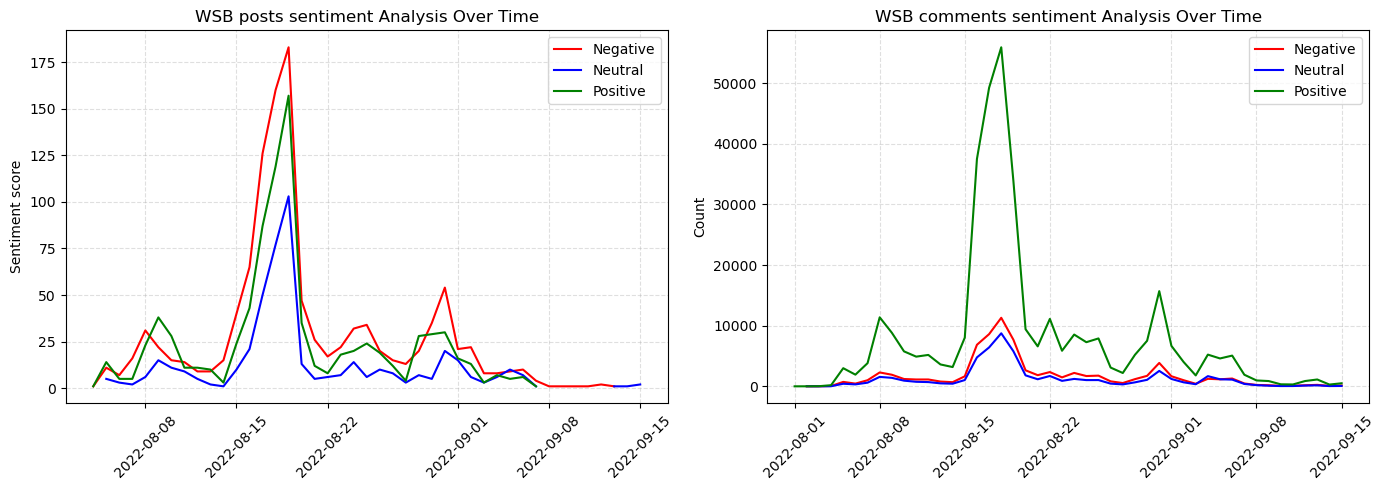

In [77]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: WSB posts sentiment analysis over time
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.plot(sentiment_pivot.index, sentiment_pivot['Negative'], label='Negative', color='red')
ax1.plot(sentiment_pivot.index, sentiment_pivot['Neutral'], label='Neutral', color='blue')
ax1.plot(sentiment_pivot.index, sentiment_pivot['Positive'], label='Positive', color='green')
ax1.set_ylabel('Sentiment score')
ax1.set_title('WSB Posts Sentiment Analysis Over Time')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Plot 2: WSB comments sentiment analysis over time
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.plot(comments_sentiment_pivot.index, comments_sentiment_pivot['Negative'], label='Negative', color='red')
ax2.plot(comments_sentiment_pivot.index, comments_sentiment_pivot['Neutral'], label='Neutral', color='blue')
ax2.plot(comments_sentiment_pivot.index, comments_sentiment_pivot['Positive'], label='Positive', color='green')
ax2.set_ylabel('Count')
ax2.set_title('WSB Comments Sentiment Analysis Over Time')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# Ensure proper spacing and display the subplots
plt.tight_layout()
plt.show()


## 4. Network analysis

### 4.1 The evolution of the discussion networks

In [79]:
# Delete first three symbols 
for comment in comments:
    if 'parent_id' in comment:
        comment['parent_id'] = comment['parent_id'][3:]
        comment['link_id'] = comment['link_id'][3:]

# Convert 'created_utc' strings to datetime objects
for comment in comments:
    try:
        utc_timestamp = int(comment['created_utc'])  # Try to convert to integer
        comment['created_utc'] = datetime.fromtimestamp(utc_timestamp)
    except ValueError:  # Skip if conversion fails
        pass

# Define the start_date and end_date for the date range
start_date = datetime(2022, 8, 1)
end_date = datetime(2022, 9, 15)

# Filter comments based on the date range
filtered_comments = [
    comment for comment in comments
    if start_date <= comment['created_utc'] <= end_date
]

In [80]:
G = nx.DiGraph()

# Create a dictionary for fast lookup
post_dict = {d['id']: d for d in posts}
comment_dict = {d['id']: d for d in comments}

for comment in filtered_comments:
    author = comment['author']
    parent_id = comment['parent_id']

    # Efficiently find parent comment or post
    parent_comment = post_dict.get(parent_id, comment_dict.get(parent_id, None))

    if parent_comment is None:
        print(f"Parent not found for id {parent_id}")
        continue

    author_parent = parent_comment['author']
    
    # Determine node color based on link_flair_css_class
    flair_class = parent_comment.get('link_flair_css_class', None)
    if flair_class in ['profit', 'loss', 'yolo']:
        node_color = 'red'
    else:
        node_color = 'lightgray'

    # Add nodes and edge
    G.add_node(author, color='lightgray')
    G.add_node(author_parent, color=node_color) 
    G.add_edge(author, author_parent)

In [81]:
# Check the number of nodes 
G.number_of_nodes()

78859

In [82]:
# Check the number of edges 
G.number_of_edges()

384370

### First time period:  August 1 - 5

In [83]:
target_node_count = 3000

G1 = nx.DiGraph()
post_dict = {d['id']: d for d in posts}
comment_dict = {d['id']: d for d in comments}

# Iterate through comments
for comment in filtered_comments:
    if len(G1) >= target_node_count:
        print(comment['created_utc'] - filtered_comments[0]['created_utc'])
        break  # Stop when the target node count is reached
        
    author = comment['author']
    parent_id = comment['parent_id']

    # find parent comment or post
    parent_comment = post_dict.get(parent_id, comment_dict.get(parent_id, None))

    if parent_comment is None:
        print(f"Parent not found for id {parent_id}")
        continue

    author_parent = parent_comment['author']
    
    # Determine node color based on link_flair_css_class
    flair_class = parent_comment.get('link_flair_css_class', None)
    if flair_class in ['profit', 'loss', 'yolo']:
        node_color = 'red'
    else:
        node_color = 'lightgray'

    # Add nodes and edge
    G1.add_node(author, color='lightgray')
    G1.add_node(author_parent, color=node_color) 
    G1.add_edge(author, author_parent)
    
# Remove self-loops from the graph if they exist
G1.remove_edges_from(nx.selfloop_edges(G1))

# Calculate the k-shell value for each node
k_shell = nx.core_number(G1)

# Create a mapping of node sizes based on k-shell values
node_sizes = [2**k_shell[node] for node in G1.nodes()]

5 days, 21:44:08


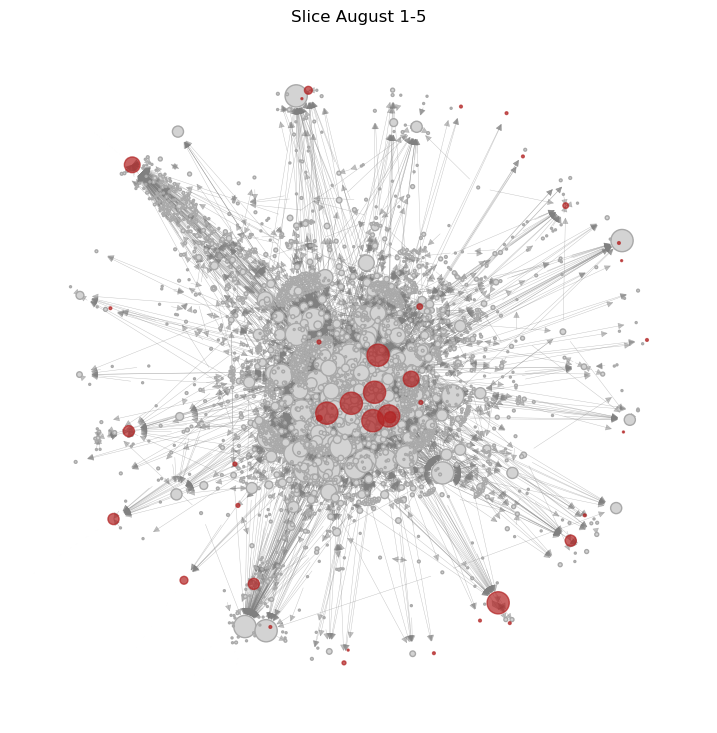

In [84]:
# Create a new figure
fig, ax = plt.subplots(figsize=(9, 9))

# Draw the graph with spring_layout
pos = nx.spring_layout(G1, k=0.05)

# Separate red and non-red nodes
red_nodes = [node for node, data in G1.nodes(data=True) if data.get('color') == 'red']
non_red_nodes = [node for node, data in G1.nodes(data=True) if data.get('color') != 'red']

#set size
red_sizes = [2**k_shell[node] for node in red_nodes]
non_red_sizes = [2**k_shell[node] for node in non_red_nodes]

# Draw non-red nodes first
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=non_red_nodes,
    node_color='lightgray',
    node_size=non_red_sizes,
    ax=ax
)

# Draw red nodes on top
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=red_nodes,
    node_color='firebrick',
    alpha=0.7, 
    node_size=red_sizes,
    ax=ax
)

# Draw edges
nx.draw_networkx_edges(G1, pos, edge_color='gray', alpha=0.5, width=0.3, ax=ax)
ax.collections[0].set_edgecolor("darkgray")

# Remove the border of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a title
ax.set_title('Slice August 1-5')

# Show the graph
plt.show();

### Second time period: August 17

In [85]:
# Define the start_date and end_date for the date range
start_date = datetime(2022, 8, 17)
end_date = datetime(2022, 9, 15)

# Filter comments based on the date range
filtered_comments2 = [
    comment for comment in comments
    if start_date <= comment['created_utc'] <= end_date
]

In [86]:
G2 = nx.DiGraph()

# Iterate through comments
for comment in filtered_comments2:
    if len(G2) >= target_node_count:
        print(comment['created_utc'] - filtered_comments2[0]['created_utc'])
        break  # Stop when the target node count is reached
        

    author = comment['author']
    parent_id = comment['parent_id']

    # find parent comment or post
    parent_comment = post_dict.get(parent_id, comment_dict.get(parent_id, None))

    if parent_comment is None:
        print(f"Parent not found for id {parent_id}")
        continue

    author_parent = parent_comment['author']

    # Determine node color based on link_flair_css_class
    flair_class = parent_comment.get('link_flair_css_class', None)
    if flair_class in ['profit', 'loss', 'yolo']:
        node_color = 'red'
    else:
        node_color = 'lightgray'

    # Add nodes and edge
    G2.add_node(author, color='lightgray')
    G2.add_node(author_parent, color=node_color) 
    G2.add_edge(author, author_parent)
    
# Remove self-loops from the graph if they exist
G2.remove_edges_from(nx.selfloop_edges(G2))

# Calculate the k-shell value for each node
k_shell = nx.core_number(G2)

# Create a mapping of node sizes based on k-shell values
node_sizes = [2**k_shell[node] for node in G2.nodes()]

3:37:44


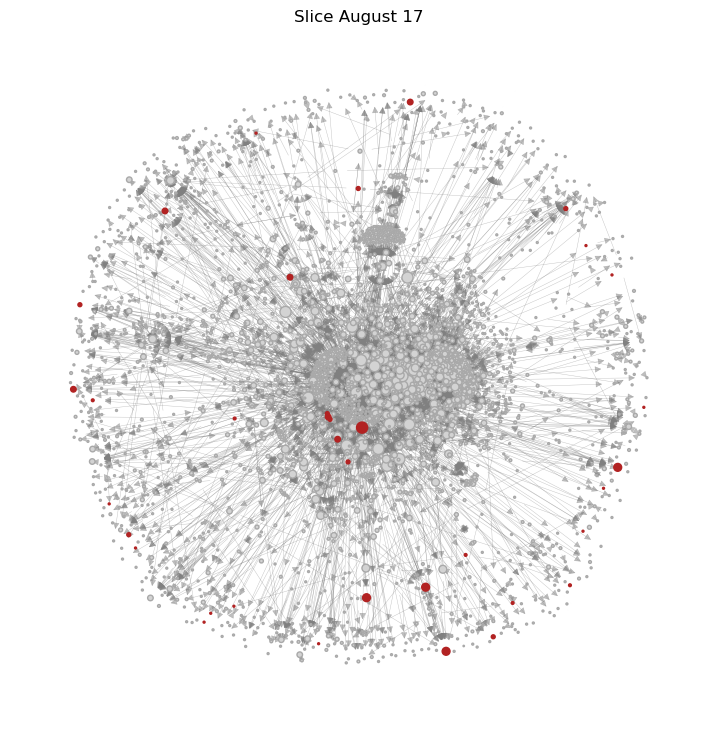

In [87]:
# Create a new figure
fig, ax = plt.subplots(figsize=(9, 9))

# Draw the graph with spring_layout
pos = nx.spring_layout(G2, k=0.05)

# Separate red and non-red nodes
red_nodes = [node for node, data in G2.nodes(data=True) if data.get('color') == 'red']
non_red_nodes = [node for node, data in G2.nodes(data=True) if data.get('color') != 'red']

#set size
red_sizes = [2**k_shell[node] for node in red_nodes]
non_red_sizes = [2**k_shell[node] for node in non_red_nodes]

# Draw non-red nodes first
nx.draw_networkx_nodes(
    G2,
    pos,
    nodelist=non_red_nodes,
    node_color='lightgray',
    node_size=non_red_sizes,
    ax=ax
)

# Draw red nodes on top
nx.draw_networkx_nodes(
    G2,
    pos,
    nodelist=red_nodes,
    node_color='firebrick',
    node_size=red_sizes,
    ax=ax
)

# Draw edges
nx.draw_networkx_edges(G2, pos, edge_color='gray', alpha=0.5, width=0.3, ax=ax)
ax.collections[0].set_edgecolor("darkgray")

# Remove the border of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a title
ax.set_title('Slice August 17')

# Show the graph
plt.show();

### Third time period: September 1

In [220]:
# Define the start_date and end_date for the date range
start_date = datetime(2022, 9, 1)
end_date = datetime(2022, 9, 15)

# Filter comments based on the date range
filtered_comments3 = [
    comment for comment in comments
    if start_date <= comment['created_utc'] <= end_date
]

In [221]:
G3 = nx.DiGraph()
post_dict = {d['id']: d for d in posts}
comment_dict = {d['id']: d for d in comments}

# Iterate through comments
for comment in filtered_comments3:
    if len(G3) >= target_node_count:
        print(comment['created_utc'] - filtered_comments3[0]['created_utc'])
        break  # Stop when the target node count is reached
        

    author = comment['author']
    parent_id = comment['parent_id']

    # find parent comment or post
    parent_comment = post_dict.get(parent_id, comment_dict.get(parent_id, None))

    if parent_comment is None:
        print(f"Parent not found for id {parent_id}")
        continue

    author_parent = parent_comment['author']
    
    # Determine node color based on link_flair_css_class
    flair_class = parent_comment.get('link_flair_css_class', None)
    if flair_class in ['profit', 'loss', 'yolo']:
        node_color = 'red'
    else:
        node_color = 'lightgray'

    # Add nodes and edge
    G3.add_node(author, color='lightgray')
    G3.add_node(author_parent, color=node_color) 
    G3.add_edge(author, author_parent)

13:35:08


In [222]:
# Remove self-loops from the graph if they exist
G3.remove_edges_from(nx.selfloop_edges(G3))

# Calculate the k-shell value for each node
k_shell = nx.core_number(G3)

# Create a mapping of node sizes based on k-shell values
node_sizes = [2**k_shell[node] for node in G3.nodes()]

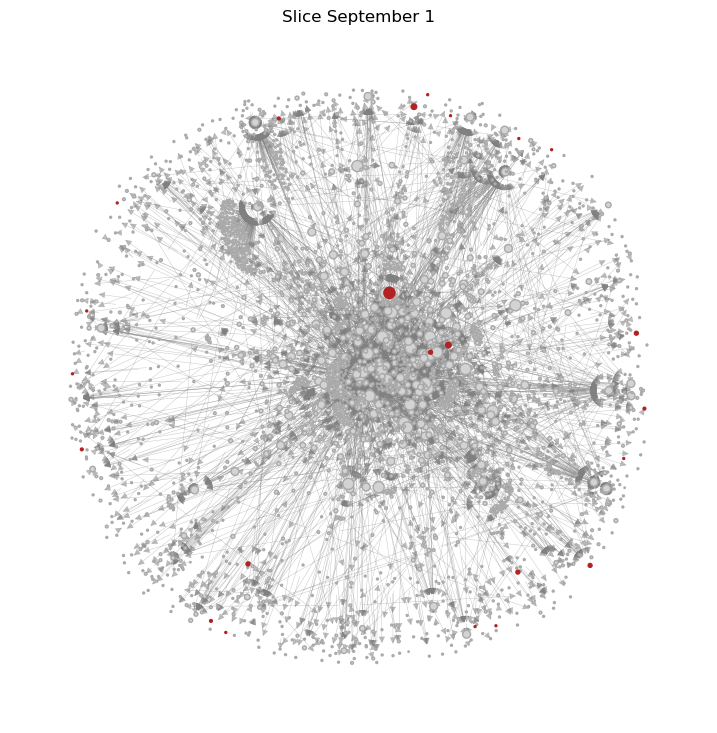

In [224]:
# Create a new figure
fig, ax = plt.subplots(figsize=(9, 9))

# Draw the graph with spring_layout
pos = nx.spring_layout(G3, k=0.05)

# Separate red and non-red nodes
red_nodes = [node for node, data in G3.nodes(data=True) if data.get('color') == 'red']
non_red_nodes = [node for node, data in G3.nodes(data=True) if data.get('color') != 'red']

#set size
red_sizes = [2**k_shell[node] for node in red_nodes]
non_red_sizes = [2**k_shell[node] for node in non_red_nodes]

# Draw non-red nodes first
nx.draw_networkx_nodes(
    G3,
    pos,
    nodelist=non_red_nodes,
    node_color='lightgray',
    node_size=non_red_sizes,
    ax=ax
)

# Draw red nodes on top
nx.draw_networkx_nodes(
    G3,
    pos,
    nodelist=red_nodes,
    node_color='firebrick',
    node_size=red_sizes,
    ax=ax
)

# Draw edges
nx.draw_networkx_edges(G3, pos, edge_color='gray', alpha=0.5, width=0.3, ax=ax)
ax.collections[0].set_edgecolor("darkgray")

# Remove the border of the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a title
ax.set_title('Slice September 1')

# Show the graph
plt.show();

### 4.2. Network metrics

In [93]:
# Filter posts based on the date range

start_date = datetime(2022, 8, 1)
end_date = datetime(2022, 9, 15)

posts = [
    post for post in posts
    if start_date.date() <= post['date'] <= end_date.date()
]

In [95]:
# Prepare data
G = nx.DiGraph()

reciprocity = []
heterogeneity = []
average_degrees = []
data = []

post_dict = {d['id']: d for d in posts}
comment_dict = {d['id']: d for d in filtered_comments}

first_date = filtered_comments[0]['created_utc']
last_date = filtered_comments[-1]['created_utc']
next_date = first_date

current_date = first_date

while next_date <= last_date:
    next_date = current_date + timedelta(days=7)

    # Efficient slicing using list comprehensions
    comments_in_window = [comment for comment in filtered_comments if current_date <= comment['created_utc'] < next_date]

    edges_to_add = []

    for comment in comments_in_window:
        author = comment['author']
        parent_id = comment['parent_id']

        parent_comment = post_dict.get(parent_id, comment_dict.get(parent_id, None))

        if parent_comment is None:
            continue

        author_parent = parent_comment['author']
        edges_to_add.append((author, author_parent))

    G.add_edges_from(edges_to_add)

    # Check if the graph is not empty

    if len(G) > 0:
        reciprocity.append(nx.reciprocity(G))

        total_degree = sum(dict(G.degree()).values())
        average_degree = total_degree / len(G)
        average_degrees.append(average_degree)

        degrees = np.array([d for n, d in G.degree()])
        N = len(degrees)

        if N > 0:  # Check to prevent division by zero
            first_moment = np.mean(degrees)
            second_moment = np.mean(degrees ** 2)
            kappa = second_moment / (first_moment ** 2)
            heterogeneity.append(kappa)

    data.append(next_date)
    G.clear()

    # Move to the next 1-day window
    current_date = current_date + timedelta(days=1)

In [97]:
rolling_window = 2  # 7-day rolling window
df = pd.DataFrame({'reciprocity': reciprocity, 'heterogeneity': heterogeneity,'date': data, 'average_degrees': average_degrees})
df.set_index('date', inplace=True)
rolling_mean = df.rolling(window=rolling_window).mean()
rolling_std = df.rolling(window=rolling_window).std()

upper_bound = rolling_mean + 2 * rolling_std
lower_bound = rolling_mean - 2 * rolling_std

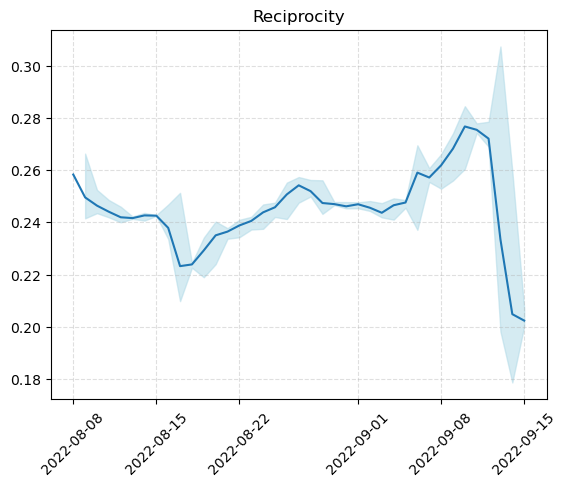

In [100]:
# Plot network reciprocity
lower = lower_bound['reciprocity']
upper = upper_bound['reciprocity']

plt.plot(data, reciprocity)
ax = plt.gca()  # Get current axis
ax.grid(True, linestyle='--', alpha=0.4)

# Adding shaded area for 2 standard deviations around the mean
plt.fill_between(data, lower, upper, color='lightblue', alpha=0.5)
plt.title('Reciprocity')
plt.xticks(rotation=45)
plt.show()

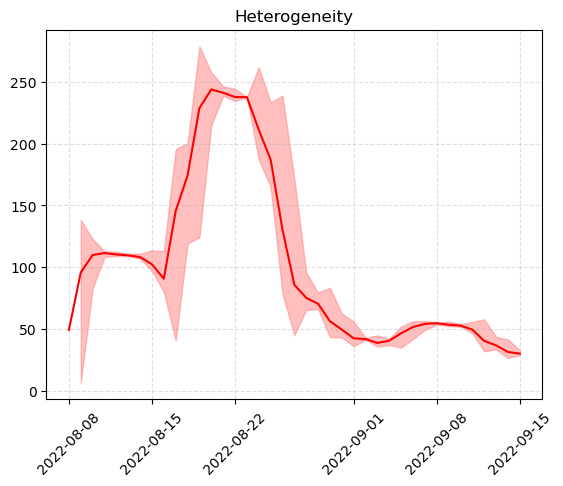

In [102]:
# Plot heterogeneity

lower = lower_bound['heterogeneity']
upper = upper_bound['heterogeneity']

plt.plot(data, heterogeneity, color = 'red')
ax = plt.gca()  # Get current axis
ax.grid(True, linestyle='--', alpha=0.4)

# Adding shaded area for 2 standard deviations around the mean
plt.fill_between(data, lower, upper, color='#FF8080', alpha=0.5)
plt.title('Heterogeneity')

plt.xticks(rotation=45)
plt.show()

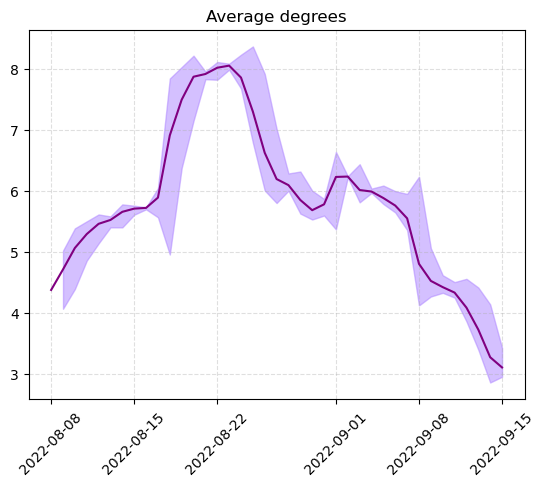

In [103]:
# Plot network average degrees
lower = lower_bound['average_degrees']
upper = upper_bound['average_degrees']

plt.plot(data, average_degrees, color = 'purple')
ax = plt.gca()  # Get current axis
ax.grid(True, linestyle='--', alpha=0.4)

# Adding shaded area for 2 standard deviations around the mean
plt.fill_between(data, lower, upper, color='#AB82FF', alpha=0.5)
plt.title('Average degrees')

plt.xticks(rotation=45)
plt.show()

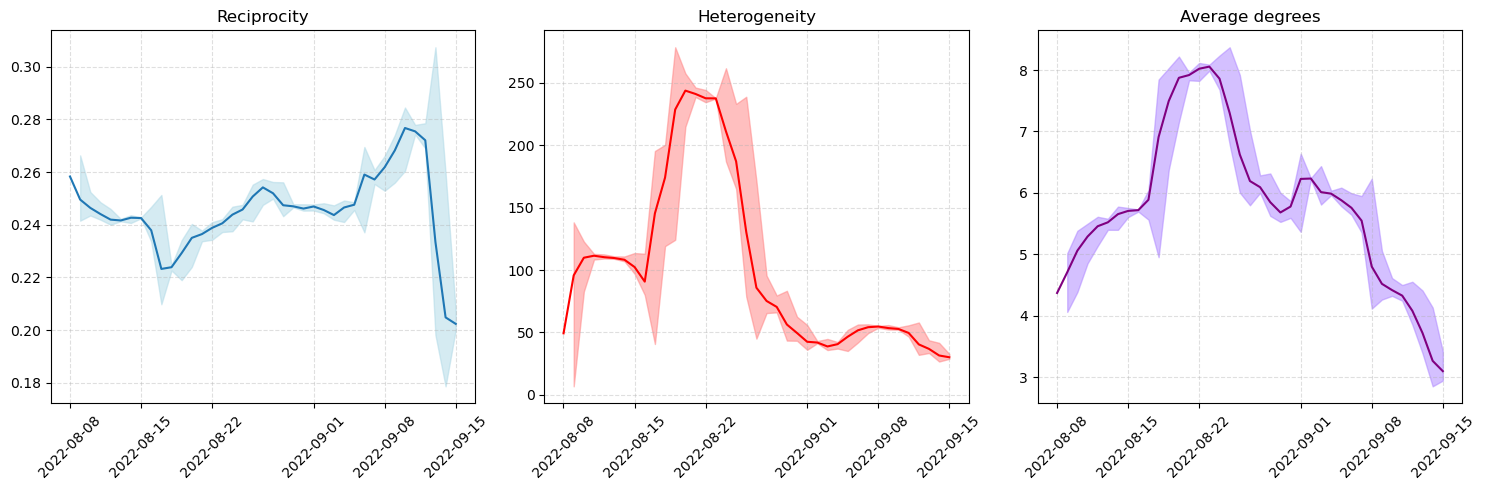

In [104]:
# Create a figure and a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot network reciprocity
lower = lower_bound['reciprocity']
upper = upper_bound['reciprocity']

axs[0].plot(data, reciprocity)
axs[0].grid(True, linestyle='--', alpha=0.4)
axs[0].fill_between(data, lower, upper, color='lightblue', alpha=0.5)
axs[0].set_title('Reciprocity')
axs[0].tick_params(axis='x', rotation=45)

# Plot heterogeneity
lower = lower_bound['heterogeneity']
upper = upper_bound['heterogeneity']

axs[1].plot(data, heterogeneity, color='red')
axs[1].grid(True, linestyle='--', alpha=0.4)
axs[1].fill_between(data, lower, upper, color='#FF8080', alpha=0.5)
axs[1].set_title('Heterogeneity')
axs[1].tick_params(axis='x', rotation=45)

# Plot network average degrees
lower = lower_bound['average_degrees']
upper = upper_bound['average_degrees']

axs[2].plot(data, average_degrees, color='purple')
axs[2].grid(True, linestyle='--', alpha=0.4)
axs[2].fill_between(data, lower, upper, color='#AB82FF', alpha=0.5)
axs[2].set_title('Average degrees')
axs[2].tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()